In [73]:
import json
import os
import sys

from datetime import datetime
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from matplotlib.dates import DateFormatter


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.data.clean_and_parse import cast_to_int
from src.utils.download import download_file_from_url
from src.utils.plot import (
    plot_bar,
    plot_hist,
    plot_pie,
    heatmap,
    PRIMARY_CMAP,
    PRIMARY_HEX,
    SECONDARY_HEX,
    TERTIARY_HEX,
)
from src.utils.states import abbrev_to_state

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/cms_puf"
OUTPUT_DATA_DIR = "./output_data/cms_puf"  # Set to None if you don't want to save non-required data for external use

In [74]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

In [75]:
# Download PUF zip
# URLs obtained by following transparency in coverage PUF links at: https://www.cms.gov/cciio/resources/data-resources/marketplace-puf
year = 2023
url = (
    f"https://download.cms.gov/marketplace-puf/{year}/transparency-in-coverage-puf.zip"
)
puf_zip_path = os.path.join(INPUT_DATA_DIR, f"transparency_in_coverage_puf_{year}.zip")
download_file_from_url(url, puf_zip_path)

# Unzip
zipdata = zipfile.ZipFile(puf_zip_path)
zipinfo = zipdata.infolist()[0]  # Single file in each zip

# Rename file to enforce consistency across years and handle with same boilerplate
zipinfo.filename = f"transparency_in_coverage_puf_{year}.xlsx"
puf_path = zipdata.extract(zipinfo, INPUT_DATA_DIR)

# Delete zip
os.remove(puf_zip_path)

Success.


### Helper Functions


In [76]:
def read_and_split_puf_sheet(puf_path, sheet_name):
    """Split off the title, legend and actual data from CMS puf sheet."""
    df = pd.read_excel(puf_path, engine="openpyxl", sheet_name=sheet_name)
    title = df.keys()[0]
    legend = df.iloc[0][0]

    # reassign header
    data = df.iloc[1:]
    headers = data.iloc[0]
    data = data[1:]
    data.columns = headers

    return title, legend, data


def get_issuer_level_dfs(dfs):
    """Isolate a dataframe containing all issuer level data for each df in dfs."""
    issuer_level_dfs = []
    for df in dfs:
        issuer_const_cols = [
            "Issuer_ID",
            "State",
            "Issuer_Name",
            "Is_Issuer_New_to_Exchange? (Yes_or_No)",
            "SADP_Only?",
            "QHP/SADP",
            "Issuer_Claims_Received",
            "Issuer_Claims_Denials",
            "Issuer_Internal_Appeals_Filed",
            "Issuer_Number_Internal_Appeals_Overturned",
            "Issuer_External_Appeals_Filed",
            "Issuer_Number_External_Appeals_Overturned",
        ]
        issuer_level_df = df.groupby(issuer_const_cols, as_index=False).first()
        issuer_level_df = issuer_level_df[issuer_const_cols]
        issuer_level_dfs.append(issuer_level_df)
    return issuer_level_dfs


def get_denial_rate(
    row, recvd_col="Issuer_Claims_Received", denied_col="Issuer_Claims_Denials"
):
    recvd = row[recvd_col]
    denied = row[denied_col]
    if recvd == 0:
        return -1
    if type(recvd) is str and type(denied) is str:
        return int(denied) / int(recvd)
    if type(recvd) is int and type(denied) is int:
        return denied / recvd
    else:
        return -1

### Read Data


In [77]:
# The Qualified Health Plan (QHP) data is delivered as a sheet in an xlsx file, but with a title row and legend row,
# which makes parsing this as a dataframe unnecessarily involved. Why, just why? Request: document the legend and title
# in a separate file or readme moving forward, so that the data can be read without having to study the header formats that seem
# to vary year to year?
sheet_name = f"Transparency {year} - Ind QHP"
title, legend, df = read_and_split_puf_sheet(puf_path, sheet_name)

In [78]:
# Legend
print(f"{title}\n\n{legend}")

Individual Marketplace Medical Qualified Health Plans (QHPs)

Legend 
*                              Data not available for this issuer/plan
**                            Suppressed data due to small cell sizes                  
***                          Data not required due to plan type
N/A                         Data not applicable because issuer or plan offering is new to the Exchange
Missing URL            Financial Link unavailable on NAIC website


### Clean and Group Data


In [79]:
def filter_rows_missing_data(
    df,
    cols=[
        "Issuer_Claims_Received",
        "Issuer_Claims_Denials",
        "Issuer_Internal_Appeals_Filed",
        "Issuer_Number_Internal_Appeals_Overturned",
        "Issuer_External_Appeals_Filed",
        "Issuer_Number_External_Appeals_Overturned",
    ],
    disallowed_values=["*", "**"],
):
    """Filter out rows for which any of the input columns contain null, * or ** values."""

    # Filter out null and disallowed strs
    filtered_df = df.copy(deep=True)
    for col in cols:
        pre_len = len(filtered_df)
        filtered_df = filtered_df[
            ~(filtered_df[col].isnull() | filtered_df[col].isin(disallowed_values))
        ]
        removed_rows = pre_len - len(filtered_df)
        if removed_rows > 0:
            print(
                f"Removed {removed_rows} rows for which column '{col}' is null or in {disallowed_values}"
            )

    return filtered_df


def retain_a_geq_b(df, a, b):
    """Retain only rows for which col a is greater than or equal to col b."""
    pre_len = len(df)
    filtered_df = df[df[a] >= df[b]]
    removed_rows = pre_len - len(filtered_df)
    if removed_rows > 0:
        print(f"Removed {removed_rows} rows reporting {b} > {a}")

    return filtered_df


def filter_erroneous_plan_claims(df):
    """Filter plan for which claims received are less than claims denied."""
    pre_len = len(df)
    filtered_df = df[df["Issuer_Claims_Received"] > df["Issuer_Claims_Denials"]]
    removed_rows = pre_len - len(filtered_df)
    if removed_rows > 0:
        print(f"Removed {removed_rows} rows reporting more denials than claims.")

    return filtered_df


def isolate_medical(df):
    df = df[df["SADP_Only?"] == "No"]
    return df


def isolate_QHP(df):
    df = df[df["QHP/SADP"] == "QHP"]
    return df

In [80]:
# Isolate QHP medical plans
df = isolate_medical(df)
df = isolate_QHP(df)

In [81]:
# Isolate issuers with denial rate data.
base_cols = ["Issuer_Claims_Received", "Issuer_Claims_Denials"]
issuer_base = filter_rows_missing_data(
    df, cols=base_cols, disallowed_values=["*", "**"]
)
issuer_base = cast_to_int(issuer_base, base_cols)
issuer_base = get_issuer_level_dfs([issuer_base])[0]
issuer_base = retain_a_geq_b(
    issuer_base, a="Issuer_Claims_Received", b="Issuer_Claims_Denials"
)

Removed 1169 rows for which column 'Issuer_Claims_Received' is null or in ['*', '**']


In [82]:
# Isolate issuers with denial rate + internal appeal result data
internal_cols = base_cols + [
    "Issuer_Internal_Appeals_Filed",
    "Issuer_Number_Internal_Appeals_Overturned",
]
issuer_internal = filter_rows_missing_data(
    df, cols=internal_cols, disallowed_values=["*", "**"]
)
issuer_internal = cast_to_int(issuer_internal, internal_cols)
issuer_internal = get_issuer_level_dfs([issuer_internal])[0]
issuer_internal = retain_a_geq_b(
    issuer_internal, a="Issuer_Claims_Received", b="Issuer_Claims_Denials"
)
issuer_internal = retain_a_geq_b(
    issuer_internal,
    a="Issuer_Internal_Appeals_Filed",
    b="Issuer_Number_Internal_Appeals_Overturned",
)

Removed 1169 rows for which column 'Issuer_Claims_Received' is null or in ['*', '**']
Removed 324 rows for which column 'Issuer_Internal_Appeals_Filed' is null or in ['*', '**']
Removed 292 rows for which column 'Issuer_Number_Internal_Appeals_Overturned' is null or in ['*', '**']
Removed 1 rows reporting Issuer_Number_Internal_Appeals_Overturned > Issuer_Internal_Appeals_Filed


In [83]:
# Isolate issuers with denial rate + internal appeal result data + external appeal data
external_cols = internal_cols + [
    "Issuer_External_Appeals_Filed",
    "Issuer_Number_External_Appeals_Overturned",
]
issuer_external = filter_rows_missing_data(
    df, cols=external_cols, disallowed_values=["*", "**"]
)
issuer_external = cast_to_int(issuer_external, external_cols)
issuer_external = get_issuer_level_dfs([issuer_external])[0]
issuer_external = retain_a_geq_b(
    issuer_external, a="Issuer_Claims_Received", b="Issuer_Claims_Denials"
)
issuer_external = retain_a_geq_b(
    issuer_external,
    a="Issuer_Internal_Appeals_Filed",
    b="Issuer_Number_Internal_Appeals_Overturned",
)
issuer_external = retain_a_geq_b(
    issuer_external,
    a="Issuer_External_Appeals_Filed",
    b="Issuer_Number_External_Appeals_Overturned",
)

Removed 1169 rows for which column 'Issuer_Claims_Received' is null or in ['*', '**']
Removed 324 rows for which column 'Issuer_Internal_Appeals_Filed' is null or in ['*', '**']
Removed 292 rows for which column 'Issuer_Number_Internal_Appeals_Overturned' is null or in ['*', '**']
Removed 1684 rows for which column 'Issuer_External_Appeals_Filed' is null or in ['*', '**']
Removed 630 rows for which column 'Issuer_Number_External_Appeals_Overturned' is null or in ['*', '**']
Removed 1 rows reporting Issuer_Number_Internal_Appeals_Overturned > Issuer_Internal_Appeals_Filed


In [84]:
# Isolate plan data with denial rate info
base_cols = ["Plan_Number_Claims_Received", "Plan_Number_Claims_Denied"]
plan_base = filter_rows_missing_data(df, cols=base_cols)
plan_base = cast_to_int(plan_base, base_cols)
plan_base = retain_a_geq_b(
    plan_base, a="Plan_Number_Claims_Received", b="Plan_Number_Claims_Denied"
)

Removed 4608 rows for which column 'Plan_Number_Claims_Received' is null or in ['*', '**']
Removed 37 rows for which column 'Plan_Number_Claims_Denied' is null or in ['*', '**']


In [85]:
# Isolate plan data with denial rate + breakdown data
inn_rationale_cols = [
    "Plan_Number_Claims_Denied_Referral_Required",
    "Plan_Number_Claims_Denied_Services_Excluded",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only",
    "Plan_Number_Claims_Denied_Other",
]
rationale_cols = inn_rationale_cols + ["Plan_Number_Claims_Denied_Out_of_Network"]
breakdown_cols = base_cols + rationale_cols
plan_breakdown = filter_rows_missing_data(df, cols=breakdown_cols)
plan_breakdown = cast_to_int(plan_breakdown, breakdown_cols)
plan_breakdown = retain_a_geq_b(
    plan_breakdown, a="Plan_Number_Claims_Received", b="Plan_Number_Claims_Denied"
)


# Enforce breakdowns consistently sum to total count
# Seems like different plans opt to include OON denials as part of total denials, others do not
plan_breakdown_oon_incl = plan_breakdown[
    plan_breakdown["Plan_Number_Claims_Denied"]
    == plan_breakdown[rationale_cols].sum(axis=1)
]
plan_breakdown_oon_excl = plan_breakdown[
    plan_breakdown["Plan_Number_Claims_Denied"]
    == plan_breakdown[inn_rationale_cols].sum(axis=1)
]

Removed 4608 rows for which column 'Plan_Number_Claims_Received' is null or in ['*', '**']
Removed 37 rows for which column 'Plan_Number_Claims_Denied' is null or in ['*', '**']
Removed 202 rows for which column 'Plan_Number_Claims_Denied_Referral_Required' is null or in ['*', '**']
Removed 118 rows for which column 'Plan_Number_Claims_Denied_Services_Excluded' is null or in ['*', '**']
Removed 400 rows for which column 'Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health' is null or in ['*', '**']
Removed 226 rows for which column 'Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only' is null or in ['*', '**']
Removed 1 rows for which column 'Plan_Number_Claims_Denied_Other' is null or in ['*', '**']
Removed 121 rows for which column 'Plan_Number_Claims_Denied_Out_of_Network' is null or in ['*', '**']


### High Level Stats


In [86]:
# Issuer data
print(f"{len(df['Issuer_ID'].unique())} issuers in data.")
print(f"{len(issuer_base)} issuers reporting data sufficient to calculate denial rate.")
print(
    f"{len(issuer_internal)} issuers reporting data sufficient to calculate internal appeal success rates."
)
print(
    f"{len(issuer_external)} issuers reporting data sufficient to calculate external appeal success rates."
)

230 issuers in data.
163 issuers reporting data sufficient to calculate denial rate.
133 issuers reporting data sufficient to calculate internal appeal success rates.
56 issuers reporting data sufficient to calculate external appeal success rates.


In [87]:
# Plan data
print(f"{len(df['Plan_ID'].unique())} plans in data.")
print(f"{len(plan_base)} plans reporting data sufficient to calculate denial rate.")
print(
    f"{len(plan_breakdown_oon_incl)} plans reporting denial rationales that sum to denied claims."
)
print(
    f"{len(plan_breakdown_oon_excl)} plans reporting denial rationales that sum to denied claims when not including OON denials."
)

6764 plans in data.
2119 plans reporting data sufficient to calculate denial rate.
382 plans reporting denial rationales that sum to denied claims.
348 plans reporting denial rationales that sum to denied claims when not including OON denials.


#### Base Denial Rates

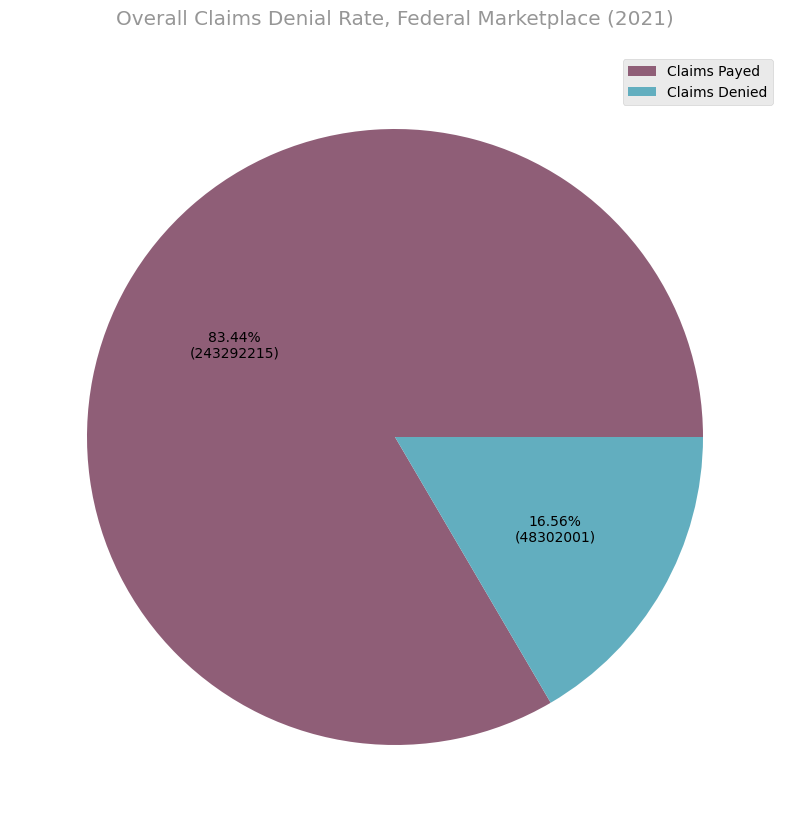

In [88]:
total_claims_received = (
    issuer_base[~issuer_base["Issuer_Claims_Received"].isnull()][
        "Issuer_Claims_Received"
    ]
    .astype(int)
    .sum()
)
total_claims_denied = (
    issuer_base[~issuer_base["Issuer_Claims_Denials"].isnull()]["Issuer_Claims_Denials"]
    .astype(int)
    .sum()
)

# Reproduce KFF Pie Chart
plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[total_claims_received - total_claims_denied, total_claims_denied],
    title="Overall Claims Denial Rate, Federal Marketplace (2021)",
    show=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overall_denial_pie.png"),
)

Question: Can we find average price of a claim to make some back of envelope calculations here about the total monetary cost being passed on to consumers (or, if denied claims result in lack of care received, value of forgone care)?

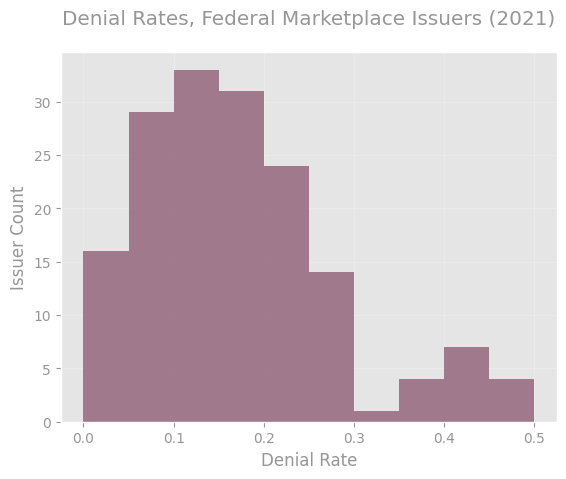

In [89]:
# Calculate issuer level denial rates
issuer_base["denial_rate"] = issuer_base.apply(get_denial_rate, axis=1)
issuer_denial_rates = issuer_base[issuer_base["denial_rate"] != -1]

# Hist
plot_hist(
    issuer_denial_rates["denial_rate"],
    bins=np.linspace(0, 0.5, 11),
    title="Denial Rates, Federal Marketplace Issuers (2021)",
    y_label="Issuer Count",
    x_label="Denial Rate",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denial_rates_all_insurers.png"),
)

# Average = ?

In [90]:
# Add summed plan level denial type breakdowns for each issuer
cat_map = {
    "Plan_Number_Claims_Denied_Referral_Required": "Referral Required",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health": "Not Medically Necessary",
    "Plan_Number_Claims_Denied_Services_Excluded": "Services Excluded",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only": "Not Medically Necessary",
    "Plan_Number_Claims_Denied_Other": "Other",
    "Plan_Number_Claims_Denied_Out_of_Network": "Out of Network",
}

for _, v in cat_map.items():
    issuer_base[v] = 0

for issuer_id in issuer_base["Issuer_ID"].unique():
    plans_w_rationales = plan_breakdown[plan_breakdown["Issuer_ID"] == issuer_id]
    tot = 0
    for k, v in cat_map.items():
        issuer_base.loc[issuer_base["Issuer_ID"] == issuer_id, v] += plans_w_rationales[
            k
        ].sum()
        tot += issuer_base.loc[issuer_base["Issuer_ID"] == issuer_id, v]

    # Number of claims received by an issuer corresponding to data from
    # which denials with rationales are populated.
    # Using Issuer_Claims_Received here would be invalid denominator
    issuer_base.loc[
        issuer_base["Issuer_ID"] == issuer_id, "claims_received_rationale_pop"
    ] = plans_w_rationales["Plan_Number_Claims_Received"].sum()
    issuer_base.loc[
        issuer_base["Issuer_ID"] == issuer_id, "claims_denied_rationale_pop"
    ] = tot

issuer_base["nmn_denial_rate"] = (
    issuer_base["Not Medically Necessary"]
    / issuer_base["claims_received_rationale_pop"]
)

In [91]:
# Inspect top k issuers (by claims adjudicated)
k = 10
top_k_insurers = issuer_base.sort_values(
    by="Issuer_Claims_Received", ascending=False
).head(k)
top_k_insurer_names = list(top_k_insurers["Issuer_Name"].values)

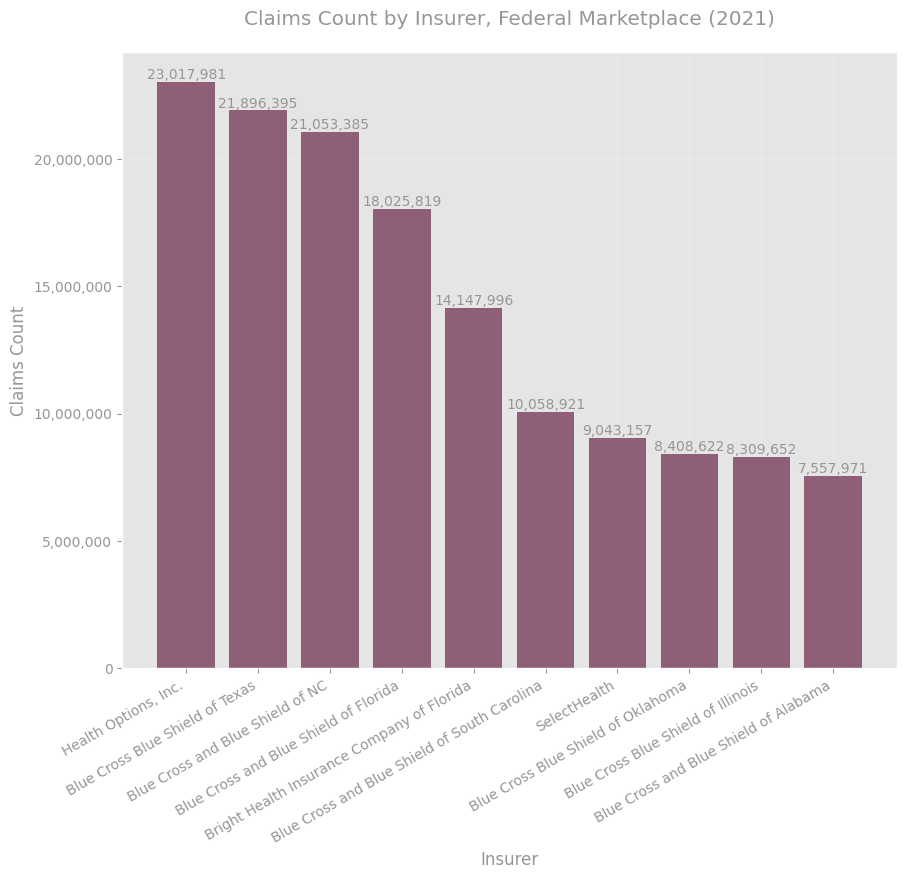

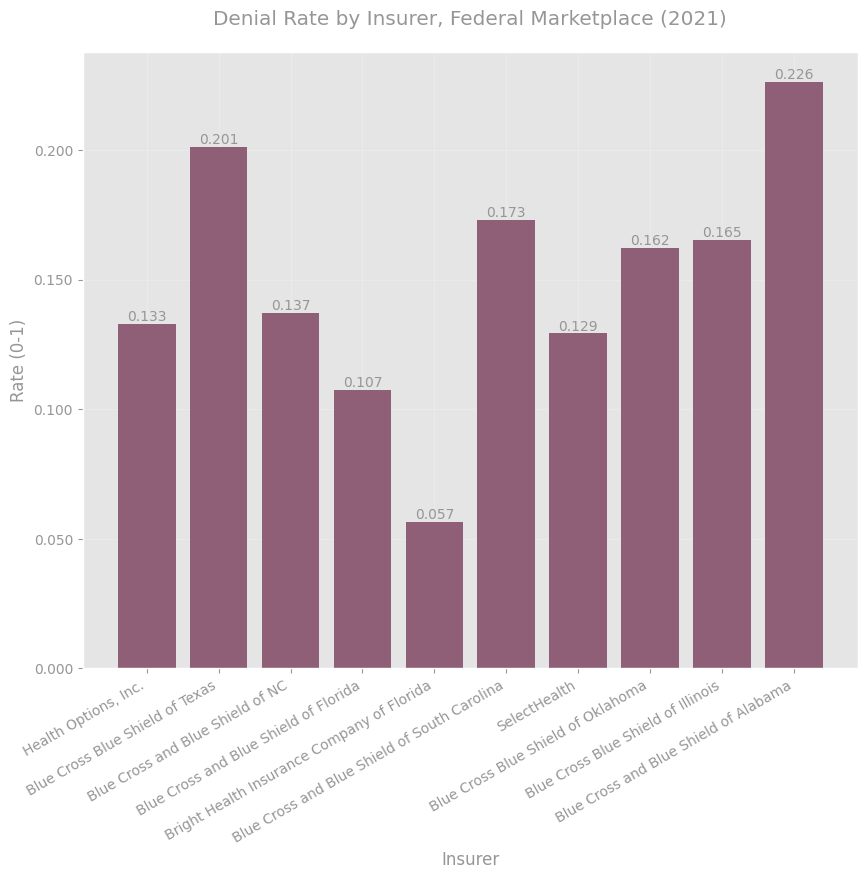

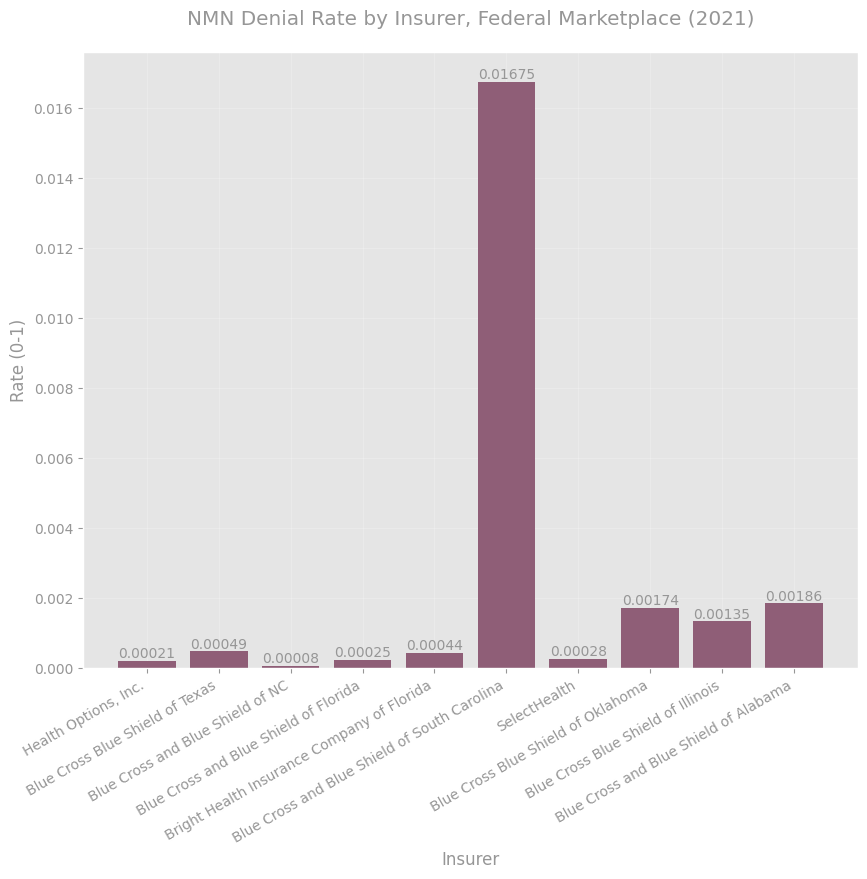

In [92]:
# Issuer Specific Claims and denial rates
bar_names = top_k_insurer_names
bar_vals = [round(x, 6) for x in top_k_insurers["Issuer_Claims_Received"]]
val_axis_label = "Claims Count"
cat_axis_label = "Insurer"
title = "Claims Count by Insurer, Federal Marketplace (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "claims_by_insurer.png"),
    bar_label=True,
    int_vals=True,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
)


bar_names = top_k_insurer_names
bar_vals = [round(x, 6) for x in top_k_insurers["denial_rate"]]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Denial Rate by Insurer, Federal Marketplace (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denial_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
)

bar_names = top_k_insurer_names
bar_vals = [round(x, 6) for x in top_k_insurers["nmn_denial_rate"]]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "NMN Denial Rate by Insurer, Federal Marketplace (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_denial_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=PRIMARY_HEX,
    figsize=(10, 8),
    float_precision_depth=5,
)

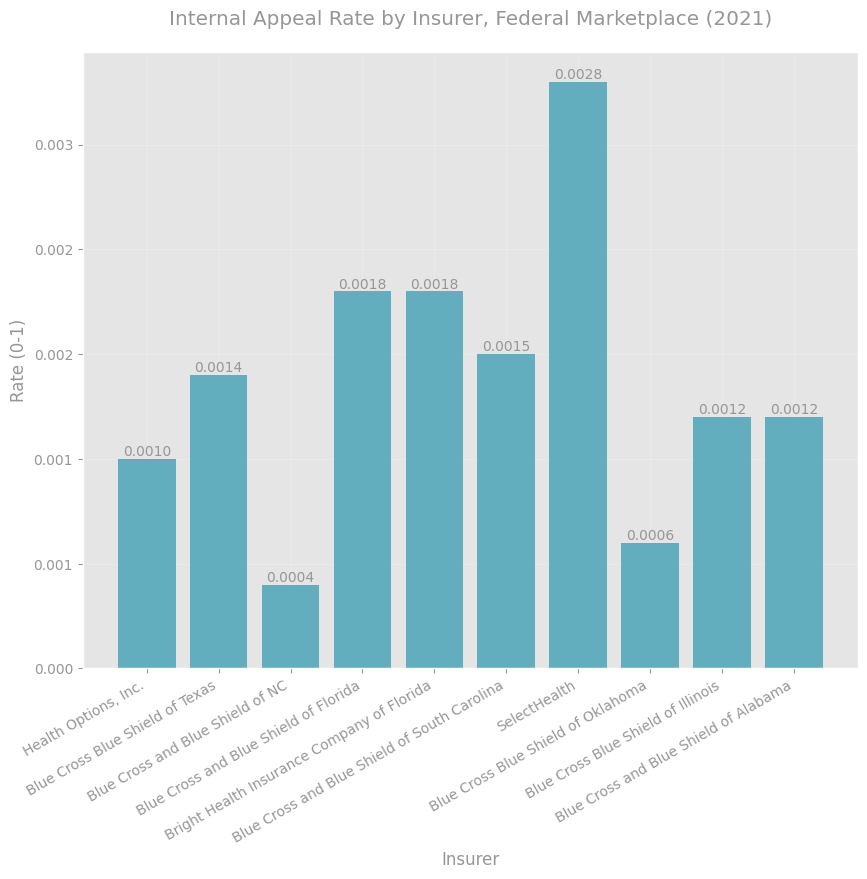

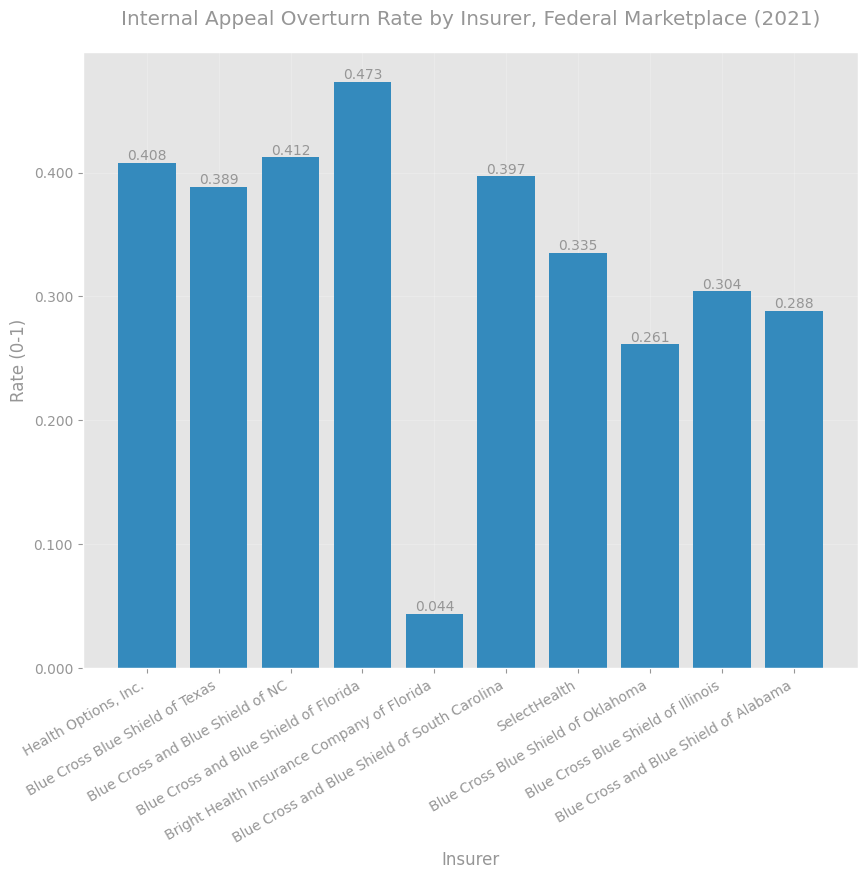

In [93]:
bar_vals = [
    round(x, 4)
    for x in top_k_insurers["Issuer_Internal_Appeals_Filed"].astype(float)
    / top_k_insurers["Issuer_Claims_Denials"].astype(float)
]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Internal Appeal Rate by Insurer, Federal Marketplace (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_rate_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    color_hex=SECONDARY_HEX,
    float_precision_depth=4,
    figsize=(10, 8),
)


bar_vals = [
    round(x, 6)
    for x in top_k_insurers["Issuer_Number_Internal_Appeals_Overturned"].astype(float)
    / top_k_insurers["Issuer_Internal_Appeals_Filed"].astype(float)
]
val_axis_label = "Rate (0-1)"
cat_axis_label = "Insurer"
title = "Internal Appeal Overturn Rate by Insurer, Federal Marketplace (2021)"
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "internal_appeal_overturn_rate_by_insurer.png"
    ),
    bar_label=True,
    int_vals=False,
    color_hex=TERTIARY_HEX,
    figsize=(10, 8),
)

In [94]:
cat_map = {
    "Plan_Number_Claims_Denied_Referral_Required": "Referral Required",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health": "Not Medically Necessary",
    "Plan_Number_Claims_Denied_Services_Excluded": "Services Excluded",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only": "Not Medically Necessary",
    "Plan_Number_Claims_Denied_Other": "Other",
    "Plan_Number_Claims_Denied_Out_of_Network": "Out of Network",
}
denial_reasons = {k: 0 for k in set(cat_map.values())}
for k, v in cat_map.items():
    denial_reasons[v] = denial_reasons[v] + int(
        pd.concat([plan_breakdown_oon_excl, plan_breakdown_oon_incl])[k].sum()
    )

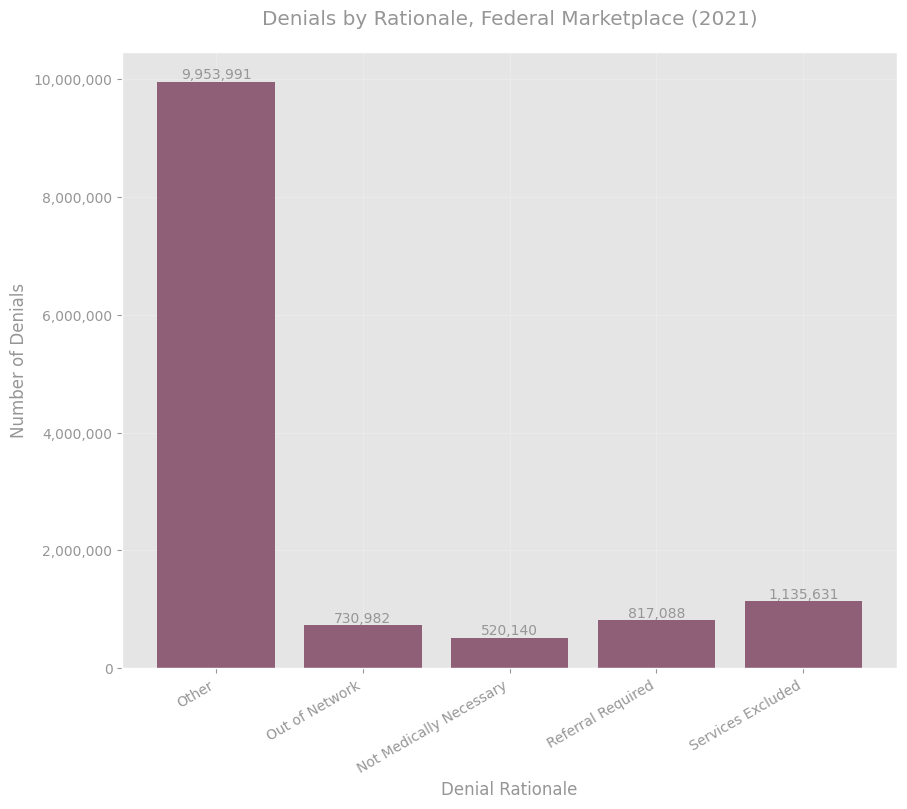

In [95]:
# Breakdown Denials by Initial Denial Rationale
# (Note: this only applies to small subset of data! Huge proportion of unknown reasons,
# and huge proportion that don't pass quality check, i.e. reasonable sum properties)
title = "Denials by Rationale, Federal Marketplace (2021)"
val_axis_label = "Number of Denials"
cat_axis_label = "Denial Rationale"

bar_names, bar_vals = list(denial_reasons.keys()), denial_reasons.values()
plot_bar(
    bar_names,
    bar_vals,
    title=title,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "denials_by_rationale.png"),
    figsize=(10, 8),
)

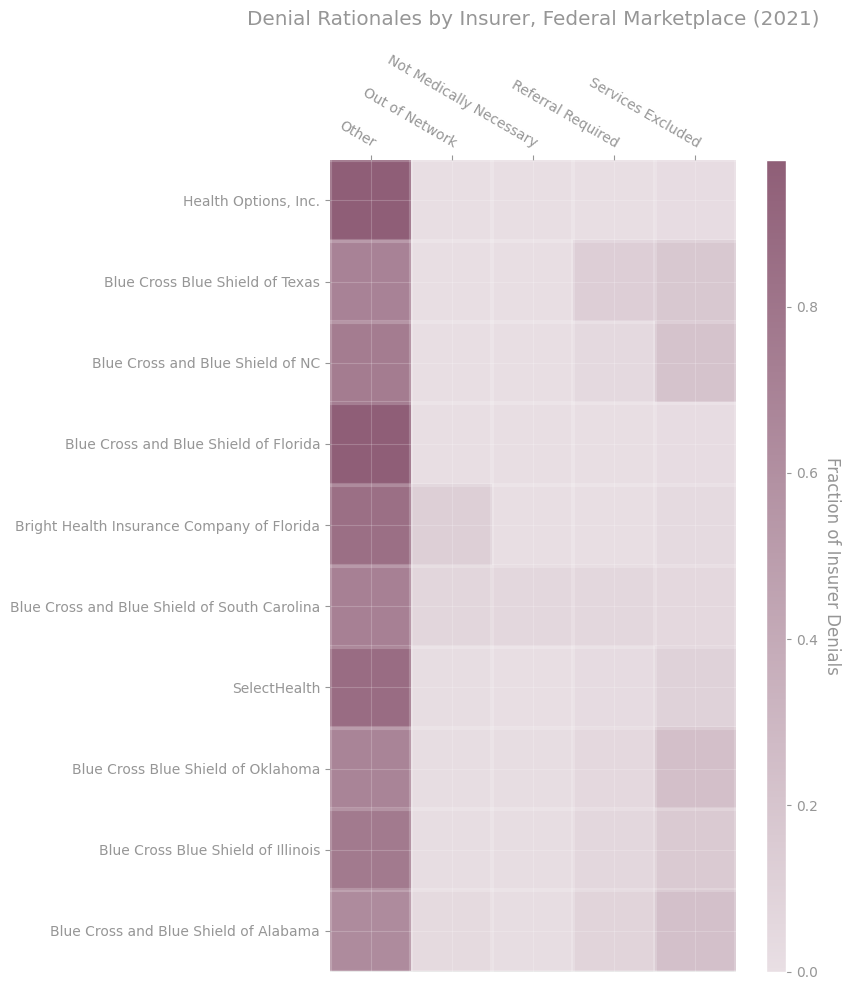

In [96]:
# Heatmap of denial rate types by insurer

insurers_col = "Issuer_Name"
total_denials_col = "claims_denied_rationale_pop"
insurer_list = top_k_insurer_names

arr = np.zeros((len(insurer_list), len(denial_reasons.keys())))
for idx, row in top_k_insurers.iterrows():
    try:
        row_idx = insurer_list.index(row[insurers_col])
        for col_idx, col in enumerate(denial_reasons.keys()):
            denial_frac = row[col] / row[total_denials_col]
            arr[row_idx, col_idx] = denial_frac
    except ValueError as e:
        pass

fig, ax = plt.subplots(figsize=(10, 10))
plt.title("Denial Rationales by Insurer, Federal Marketplace (2021)")

heat_val_name = f"Fraction of Insurer Denials"
im, cbar = heatmap(
    arr,
    top_k_insurer_names,
    denial_reasons.keys(),
    ax=ax,
    cmap=PRIMARY_CMAP,
    cbarlabel=heat_val_name,
    cbar_kw={"shrink": 0.3},
)

fig.tight_layout()
save_path = os.path.join(OUTPUT_IMAGE_DIR, "insurer_vs_denial_cat.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

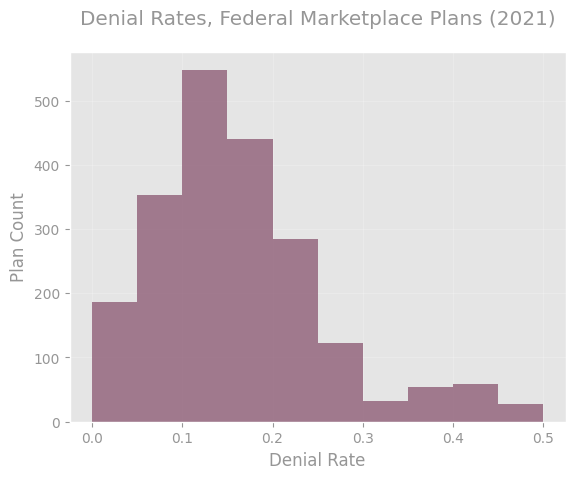

In [97]:
# Calculate plan level denial rates
plan_base["denial_rate"] = plan_base.apply(
    partial(
        get_denial_rate,
        recvd_col="Plan_Number_Claims_Received",
        denied_col="Plan_Number_Claims_Denied",
    ),
    axis=1,
)
plan_denial_rates = plan_base[plan_base["denial_rate"] != -1]

# Hist
plot_hist(
    plan_denial_rates["denial_rate"],
    bins=np.linspace(0, 0.5, 11),
    title="Denial Rates, Federal Marketplace Plans (2021)",
    y_label="Plan Count",
    x_label="Denial Rate",
)

# Average = ?

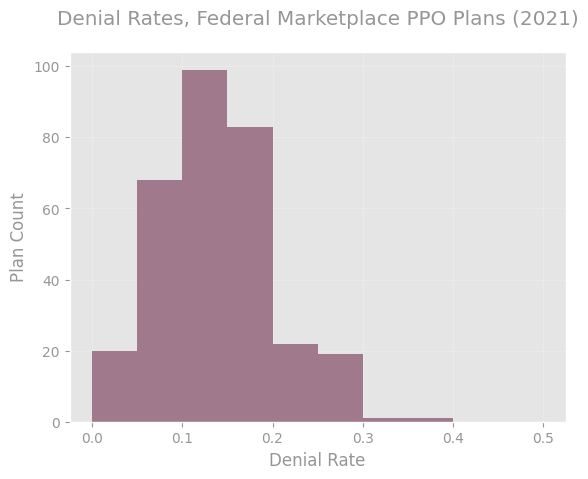

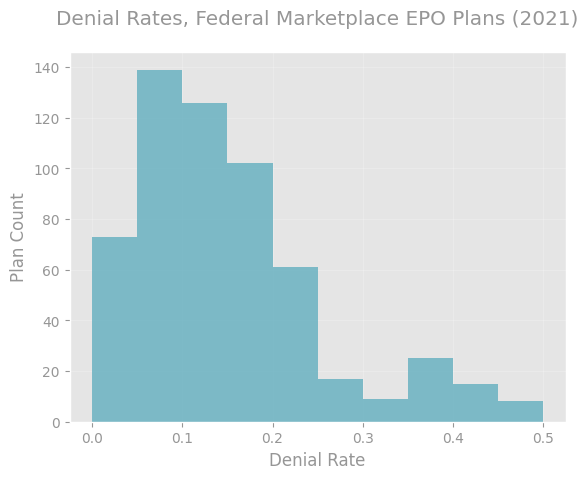

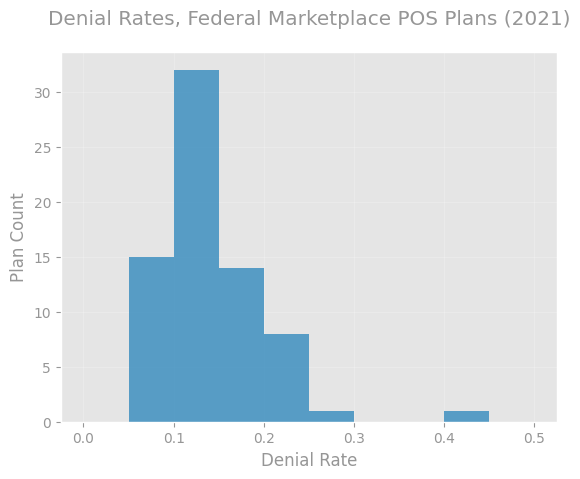

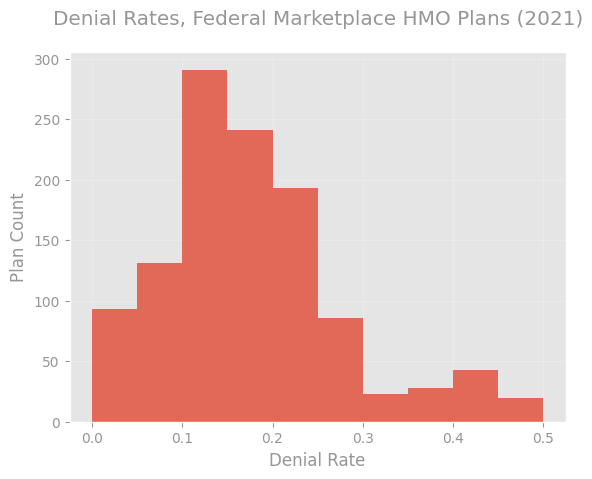

In [98]:
# Break down by plan type
plan_types = plan_base["Plan_Type"].unique()
cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for idx, ptype in enumerate(plan_types):
    fig, ax = plt.subplots()
    type_dist = plan_base[plan_base["Plan_Type"] == ptype]["denial_rate"]
    ax.hist(type_dist, alpha=0.8, bins=np.linspace(0, 0.5, 11), color=cycle[idx])
    ax.set_title(f"Denial Rates, Federal Marketplace {ptype} Plans (2021)")
    ax.set_ylabel("Plan Count")
    ax.set_xlabel("Denial Rate")
    plt.show()

In [99]:
# Export this as json for external use
if OUTPUT_DATA_DIR:
    denial_rates_by_plan_type = {}
    for ptype in plan_types:
        type_dist = plan_base[plan_base["Plan_Type"] == ptype]["denial_rate"]
        denial_rates_by_plan_type[ptype] = list(type_dist.values)
    with open(
        os.path.join(OUTPUT_DATA_DIR, "denial_rates_by_plan_type.json"), "w"
    ) as outfile:
        json.dump(denial_rates_by_plan_type, outfile)

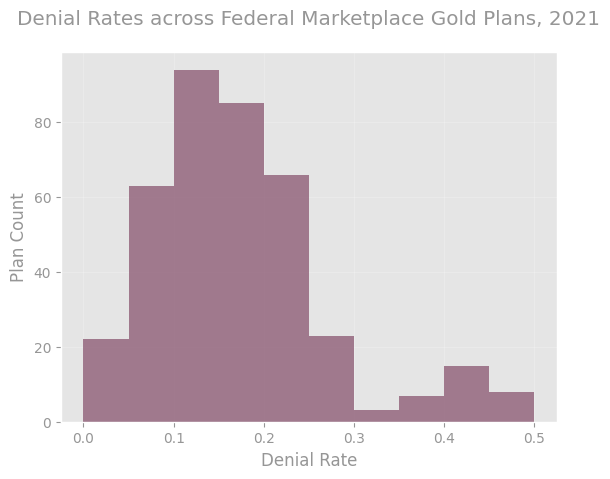

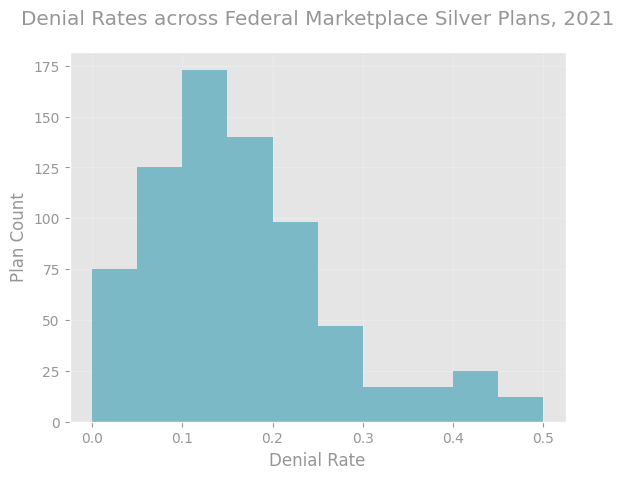

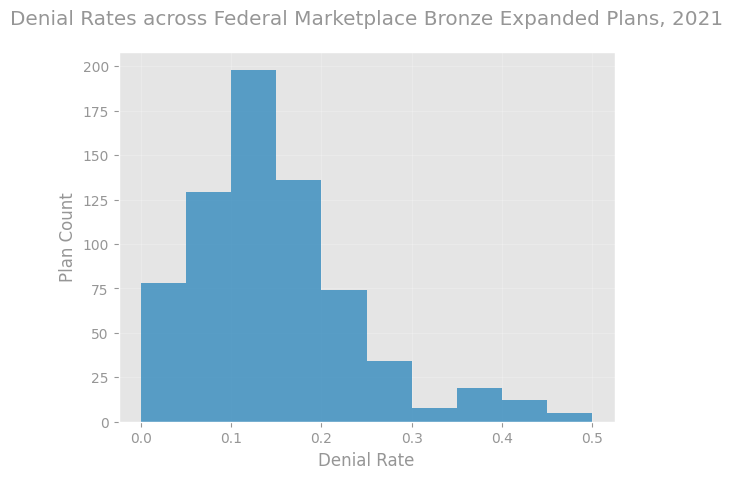

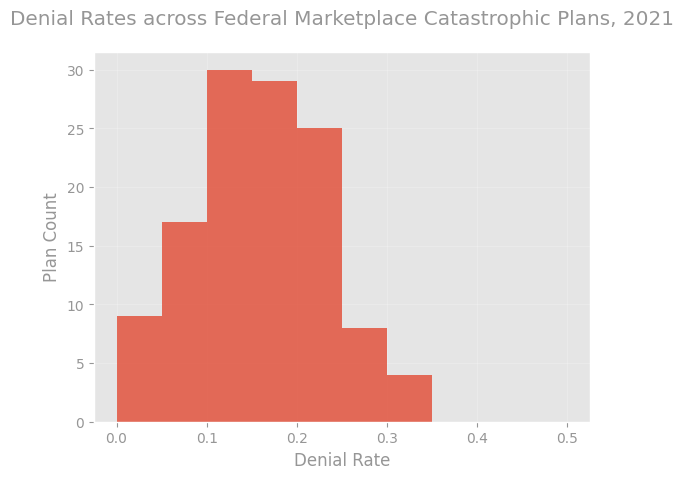

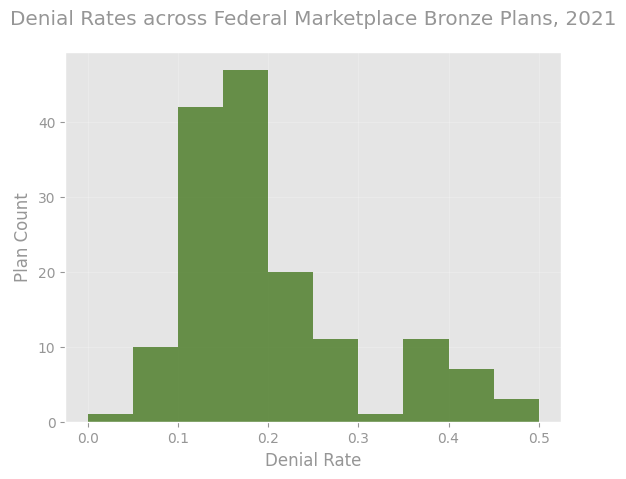

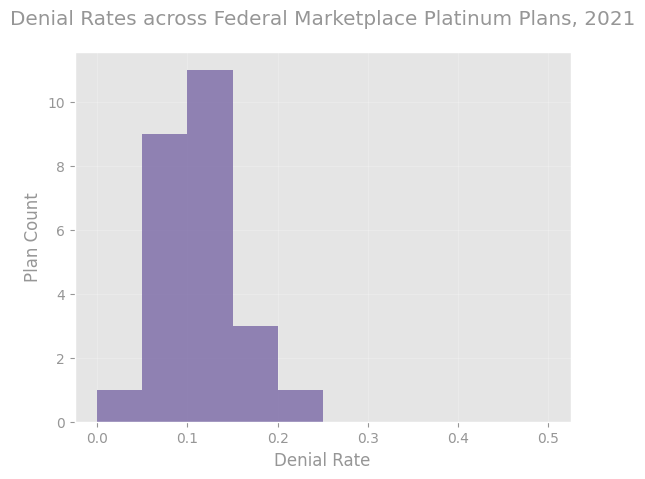

In [100]:
# Break down by metal level
plan_metals = plan_base["Metal_Level"].unique()
cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for idx, mtype in enumerate(plan_metals):
    fig, ax = plt.subplots()
    type_dist = plan_base[plan_base["Metal_Level"] == mtype]["denial_rate"]
    ax.hist(type_dist, alpha=0.8, bins=np.linspace(0, 0.5, 11), color=cycle[idx])
    ax.set_title(f"Denial Rates across Federal Marketplace {mtype} Plans, 2021")
    ax.set_ylabel("Plan Count")
    ax.set_xlabel("Denial Rate")
    plt.show()

In [101]:
# Export this as json for external use
if OUTPUT_DATA_DIR:
    denial_rates_by_metal_type = {}
    for mtype in plan_metals:
        type_dist = plan_base[plan_base["Metal_Level"] == mtype]["denial_rate"]
        denial_rates_by_metal_type[mtype] = list(type_dist.values)
    with open(
        os.path.join(OUTPUT_DATA_DIR, "denial_rates_by_metal_type.json"), "w"
    ) as outfile:
        json.dump(denial_rates_by_metal_type, outfile)

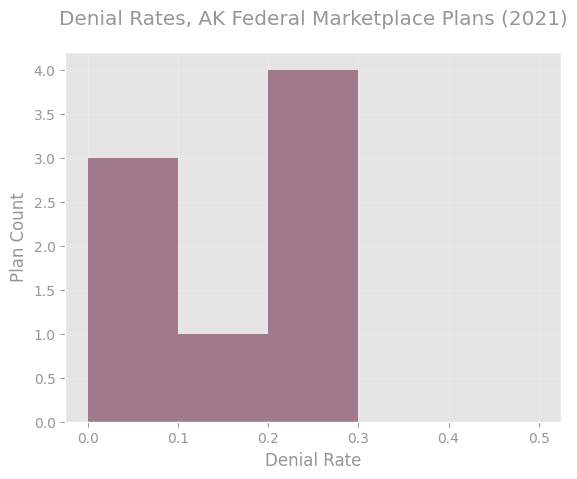

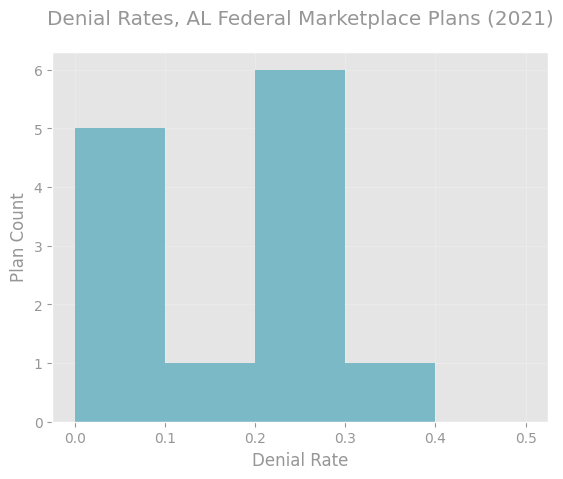

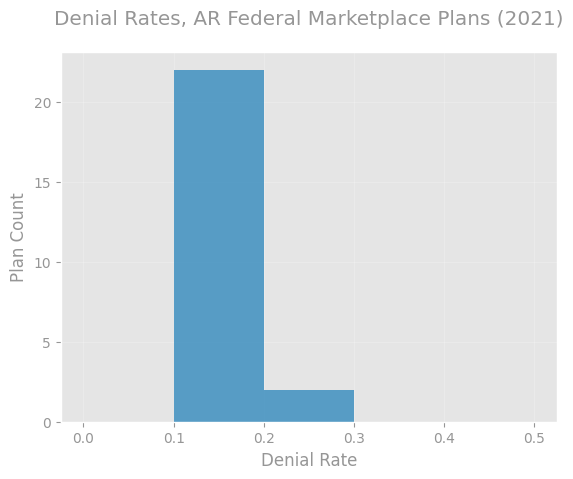

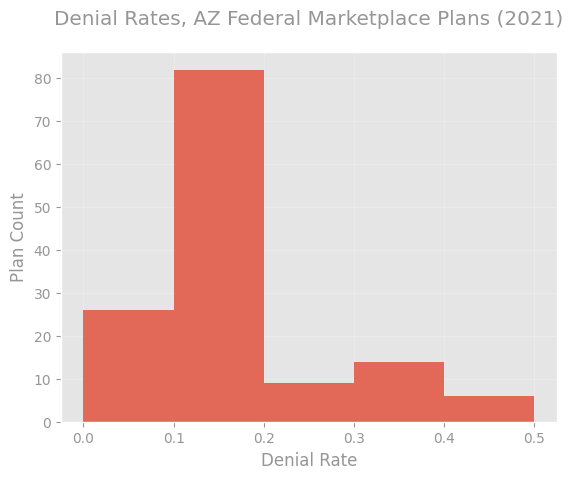

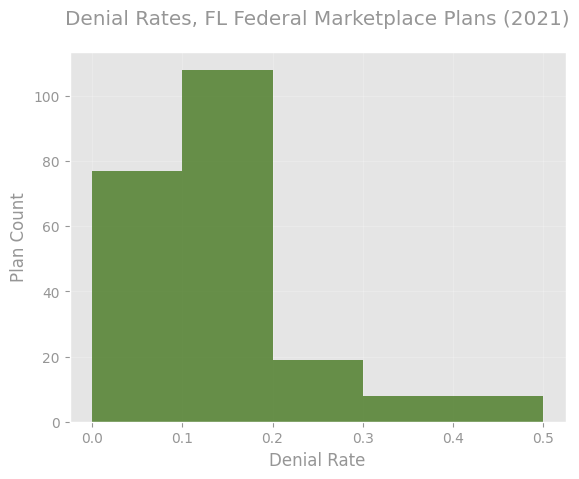

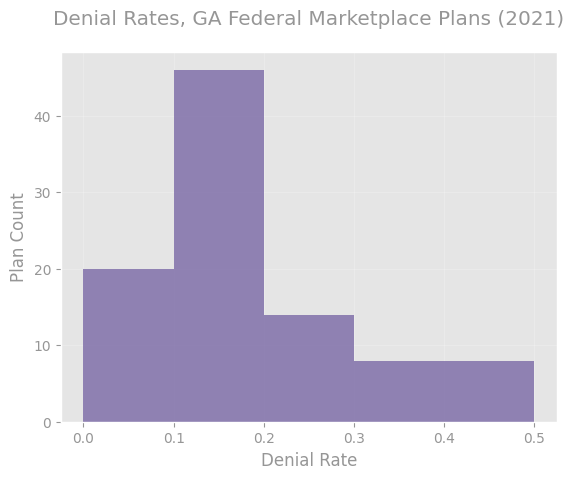

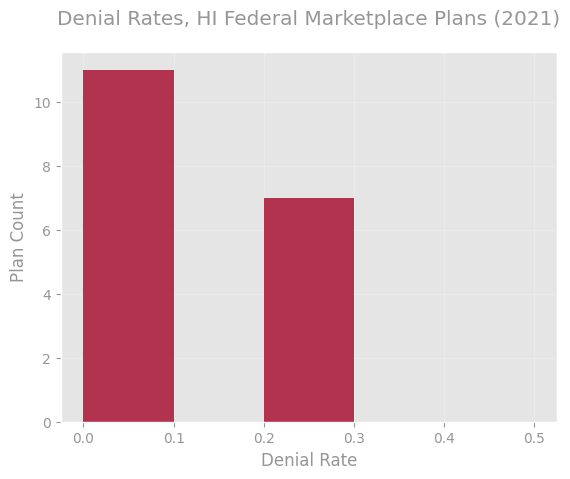

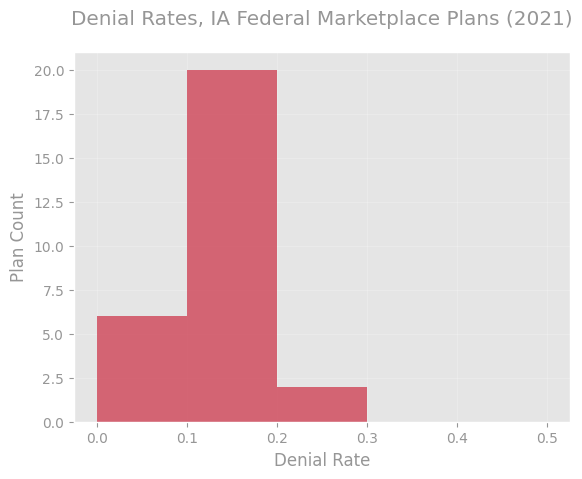

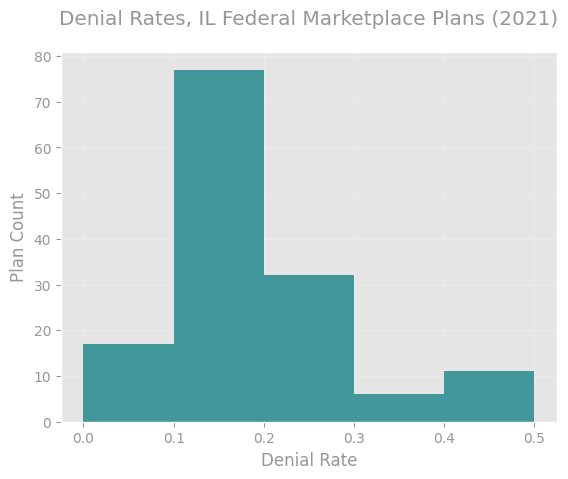

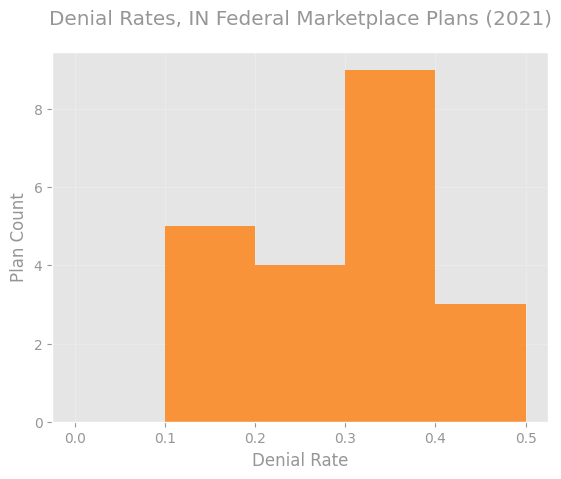

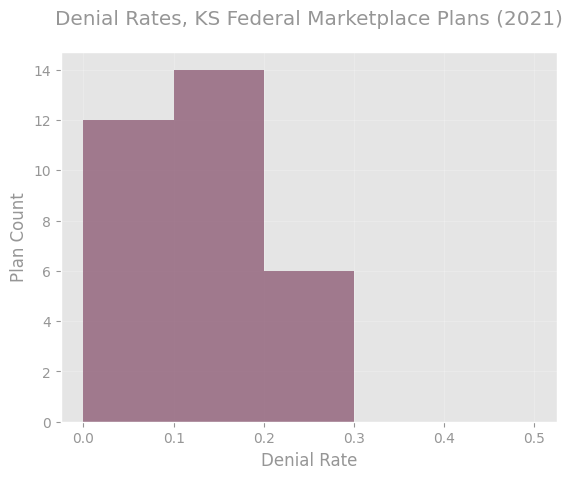

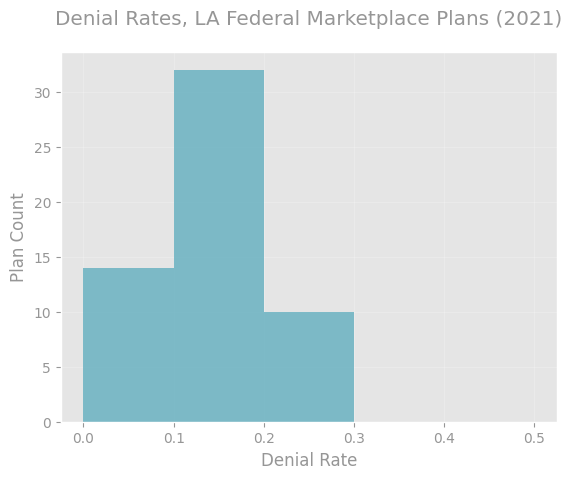

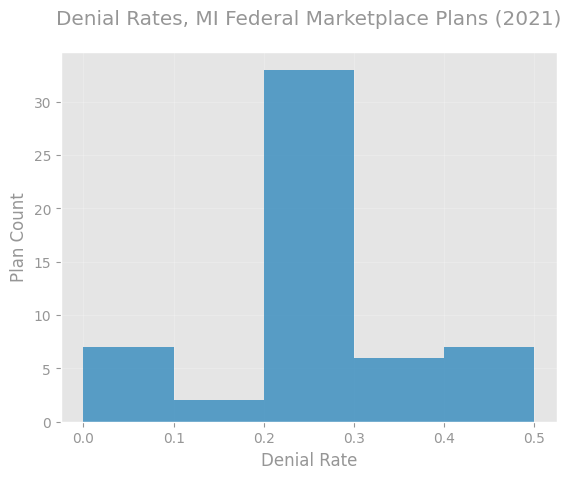

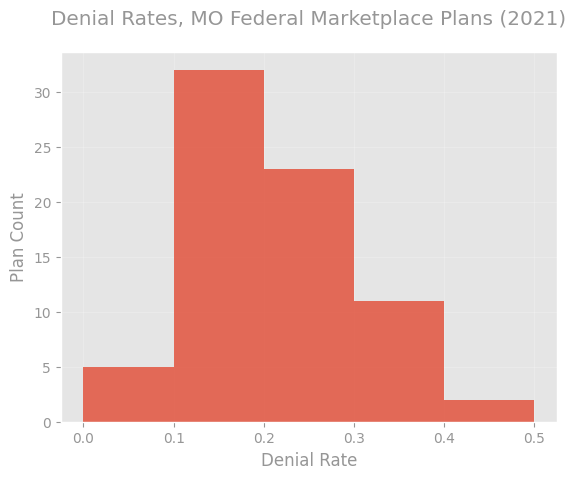

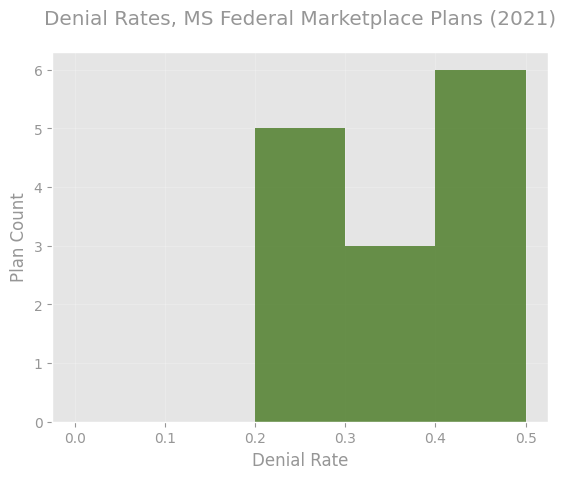

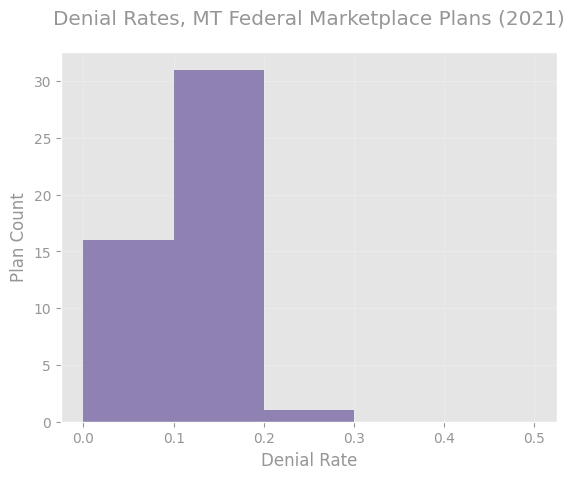

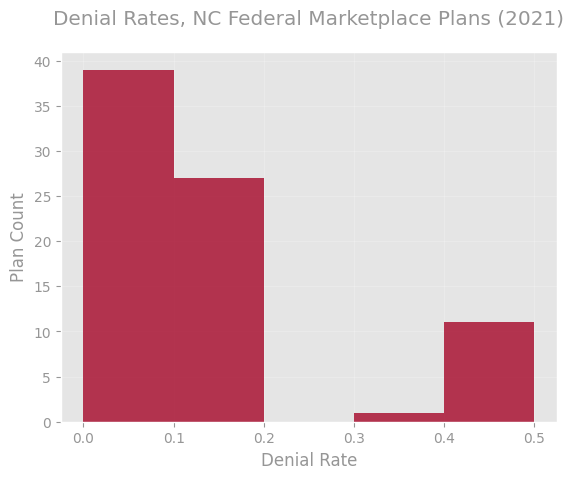

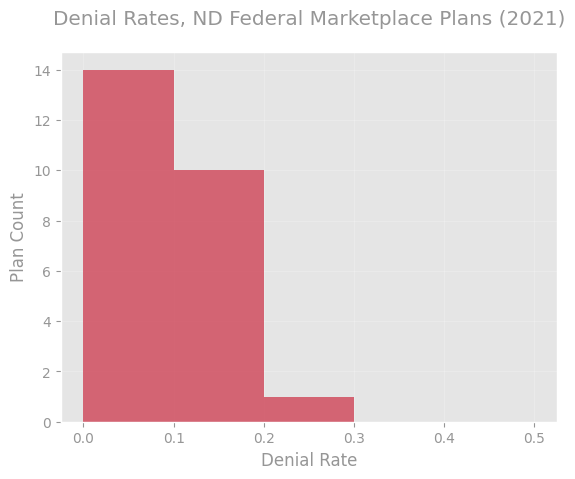

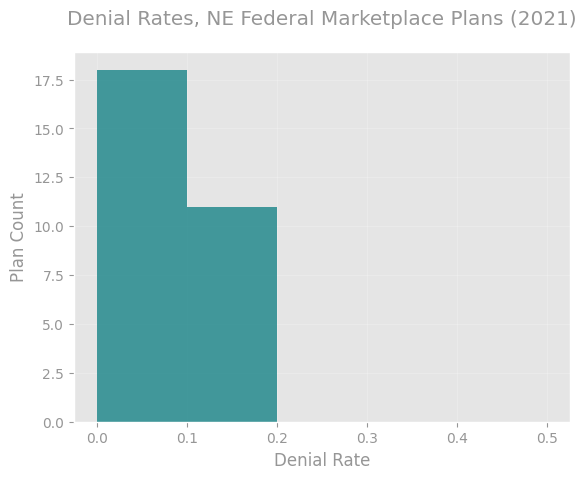

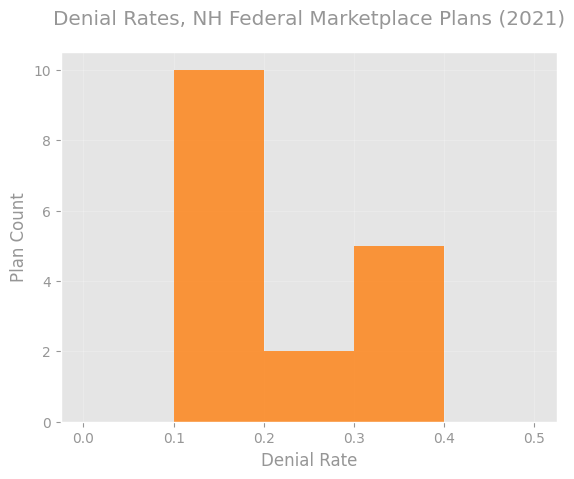

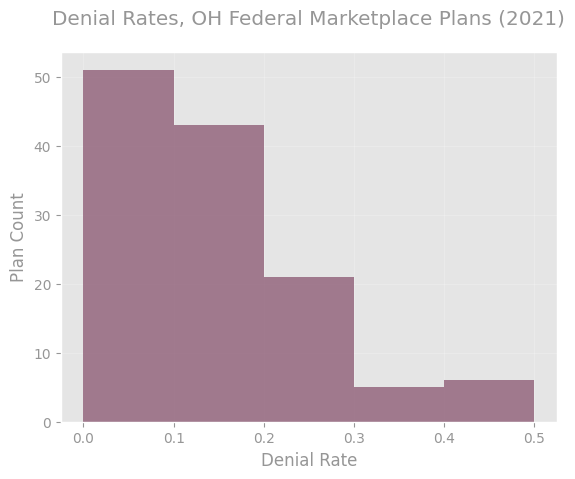

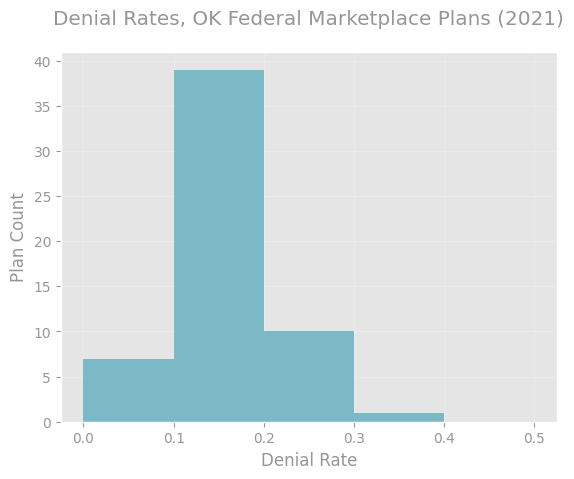

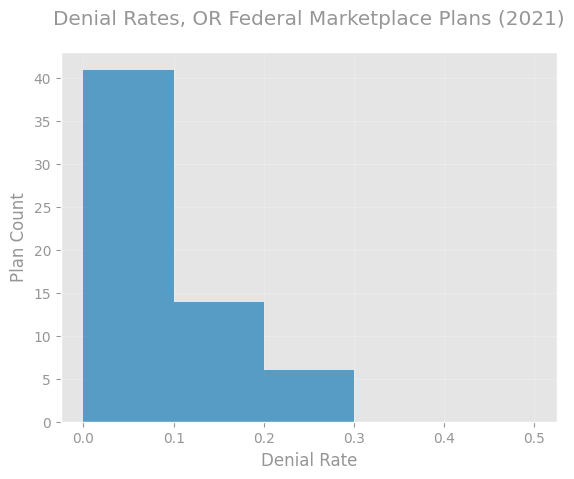

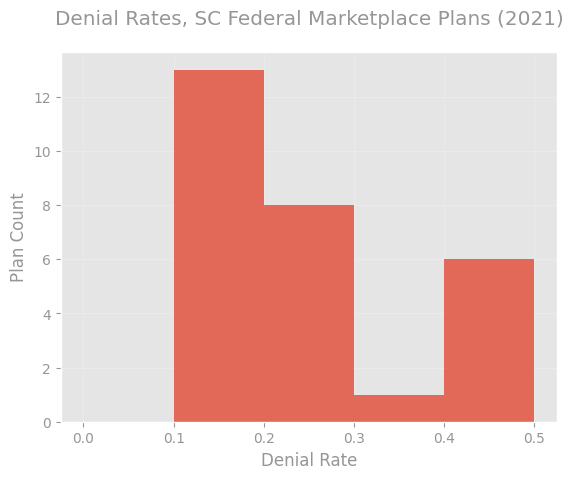

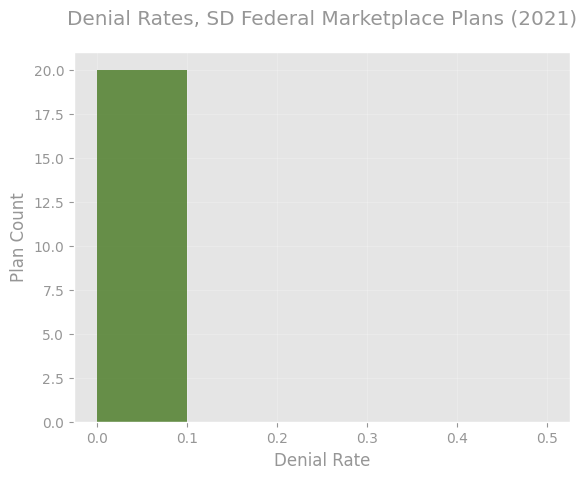

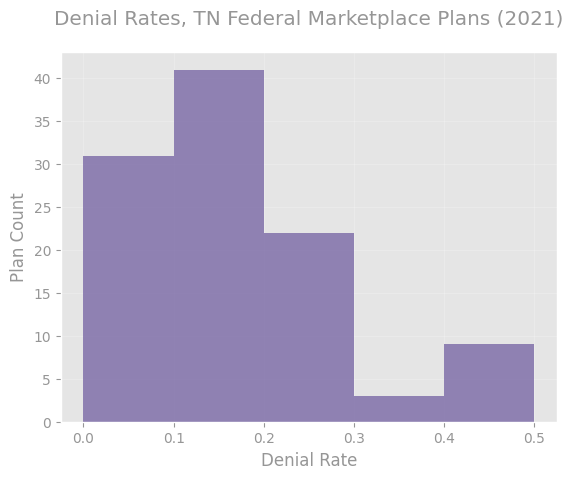

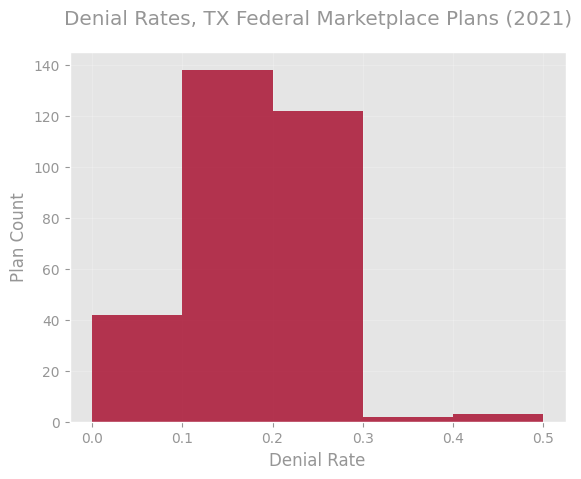

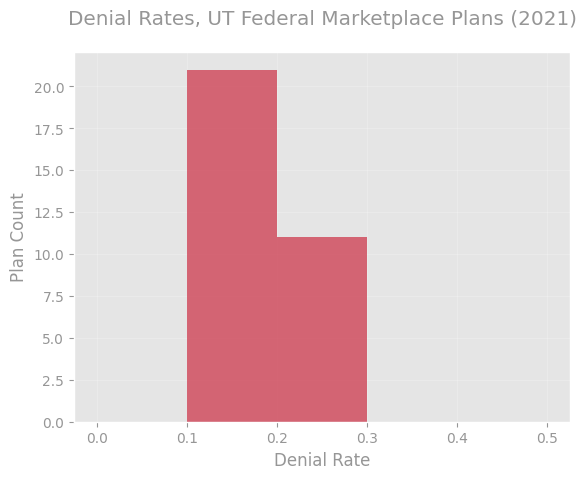

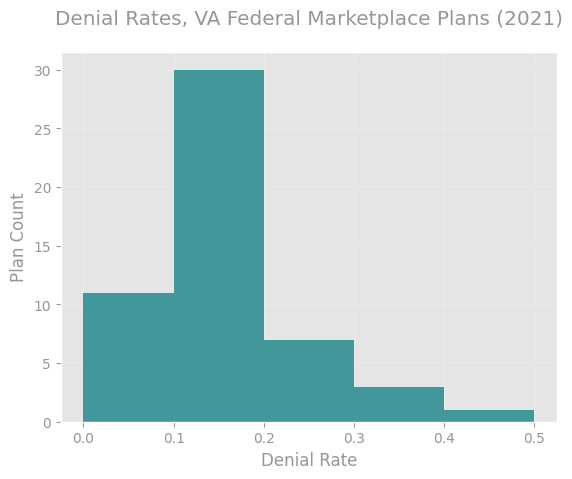

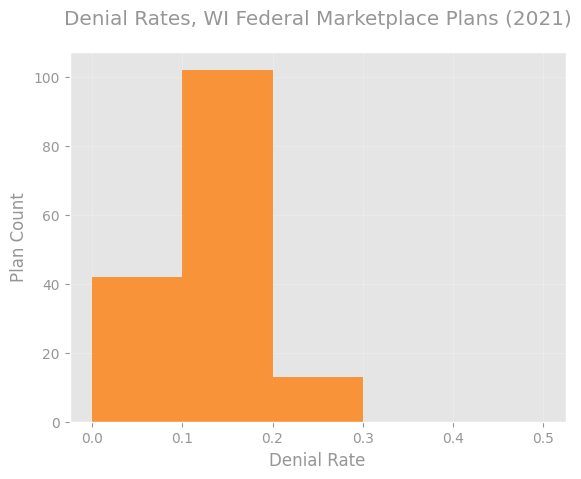

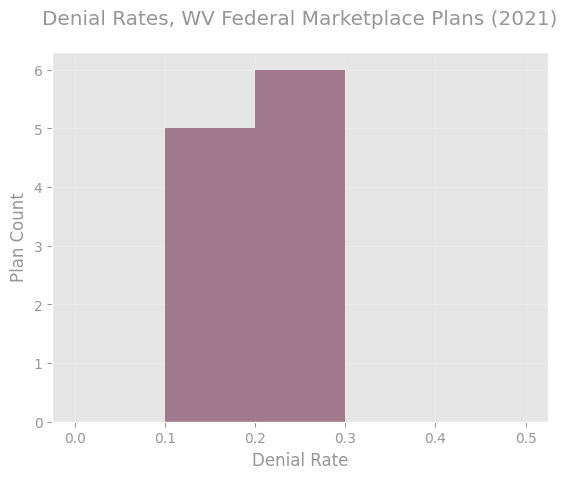

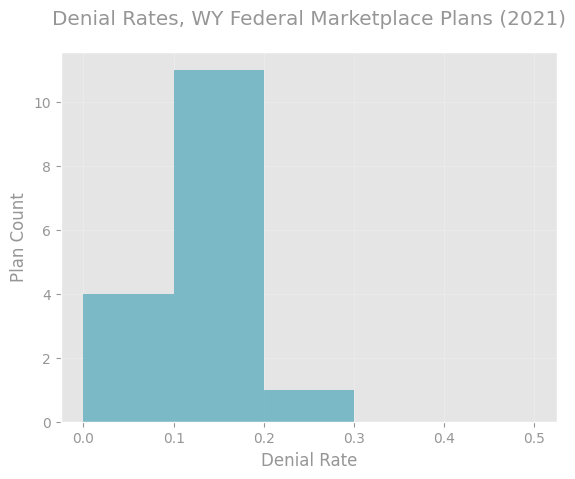

In [102]:
# Break down by state
plan_states = sorted(plan_base["State"].unique())
cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for idx, state in enumerate(plan_states):
    fig, ax = plt.subplots()
    type_dist = plan_base[plan_base["State"] == state]["denial_rate"]
    ax.hist(
        type_dist, alpha=0.8, bins=np.linspace(0, 0.5, 6), color=cycle[idx % len(cycle)]
    )
    ax.set_title(f"Denial Rates, {state} Federal Marketplace Plans (2021)")
    ax.set_ylabel("Plan Count")
    ax.set_xlabel("Denial Rate")
    plt.show()

# TODO: Make js component to show hists in addition to average denial rate for each state.

In [103]:
if OUTPUT_DATA_DIR:
    # Create json of state denial rates
    state_denial_data = {}
    issuer_states = sorted(issuer_base["State"].unique())
    for idx, state in enumerate(plan_states):
        state_issuers = issuer_base[issuer_base["State"] == state]
        state_issuers_sorted = state_issuers.sort_values(
            by="Issuer_Claims_Denials", ascending=False
        )
        total_received = int(state_issuers_sorted["Issuer_Claims_Received"].sum())
        total_denied = int(state_issuers_sorted["Issuer_Claims_Denials"].sum())
        denial_rate = round(total_denied / total_received, 3)
        state_issuers = state_issuers_sorted["Issuer_Name"].values
        top_issuers = list(state_issuers[:3])
        num_issuers = len(state_issuers)

        # Drop plans with undisclosed enrollment (then values we report are a guaranteed lower bound, rather than unknown error type, assuming accurate reporting)
        enrolled_consumers = plan_base[plan_base["State"] == state][
            "Average Monthly Enrollment"
        ]
        enrolled_consumers = enrolled_consumers[enrolled_consumers != "*"]
        enrolled_consumers = enrolled_consumers.astype(int).sum()

        # Total issuers represented
        state_denial_data[state] = {
            "claims_received": total_received,
            "claims_denied": total_denied,
            "denial_rate": denial_rate,
            "top_issuers": top_issuers,
            "num_issuers_represented": num_issuers,
            "consumers_reported": int(enrolled_consumers),
        }
    with open(os.path.join(OUTPUT_DATA_DIR, "state_denial_data.json"), "w") as outfile:
        json.dump(state_denial_data, outfile)

    # Also store markdown
    states = []
    denial_rates = []
    claims_received = []
    claims_denied = []
    consumers_represented = []
    insurers_represented = []
    for abbrev, state_data in state_denial_data.items():
        states.append(abbrev_to_state[abbrev])
        denial_rates.append(state_data["denial_rate"])
        claims_received.append(state_data["claims_received"])
        claims_denied.append(state_data["claims_denied"])
        consumers_represented.append(state_data["consumers_reported"])
        insurers_represented.append(state_data["num_issuers_represented"])
    tabular_rep = pd.DataFrame(
        data={
            "State or Region": states,
            "Overall Denial Rate": denial_rates,
            "Claims Received": claims_received,
            "Claims Denied": claims_denied,
            "Number of Consumers Reported": consumers_represented,
            "Number of Insurers Reported": insurers_represented,
        }
    )

#### Appeal Rates

##### Among Issuers Reporting Internal Appeals Data

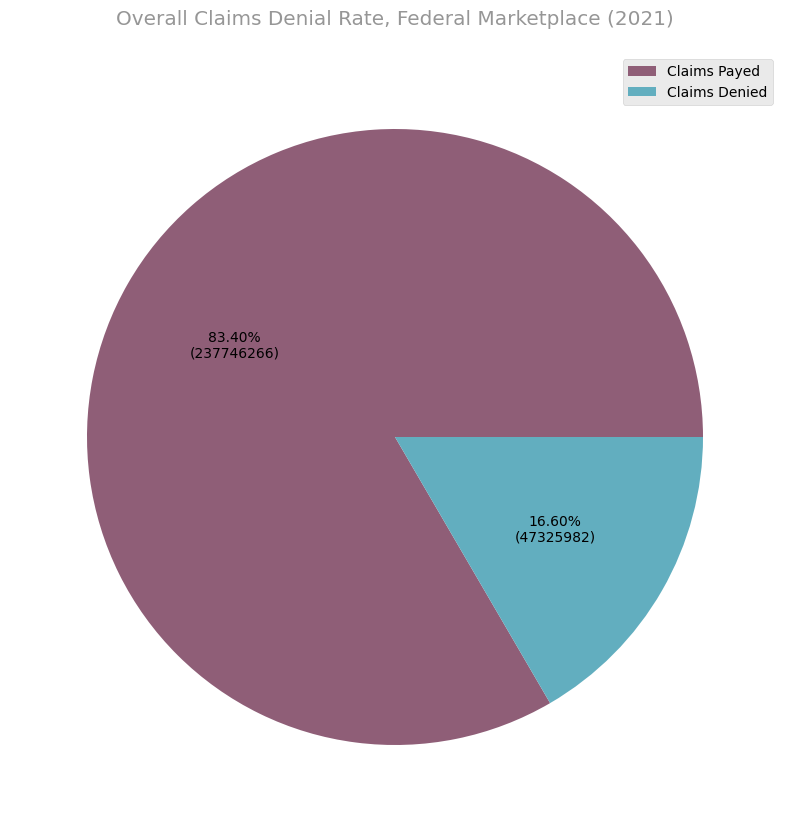

In [104]:
#### Denial Rate Among those reporting Internal Appeals
claims_received = (
    issuer_internal[~issuer_internal["Issuer_Claims_Received"].isnull()][
        "Issuer_Claims_Received"
    ]
    .astype(int)
    .sum()
)
claims_denied = (
    issuer_internal[~issuer_internal["Issuer_Claims_Denials"].isnull()][
        "Issuer_Claims_Denials"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=["Claims Payed", "Claims Denied"],
    slice_vals=[claims_received - claims_denied, claims_denied],
    title="Overall Claims Denial Rate, Federal Marketplace (2021)",
    show=True,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "denial_rates_insurers_w_internal_appeal_data.png"
    ),
)

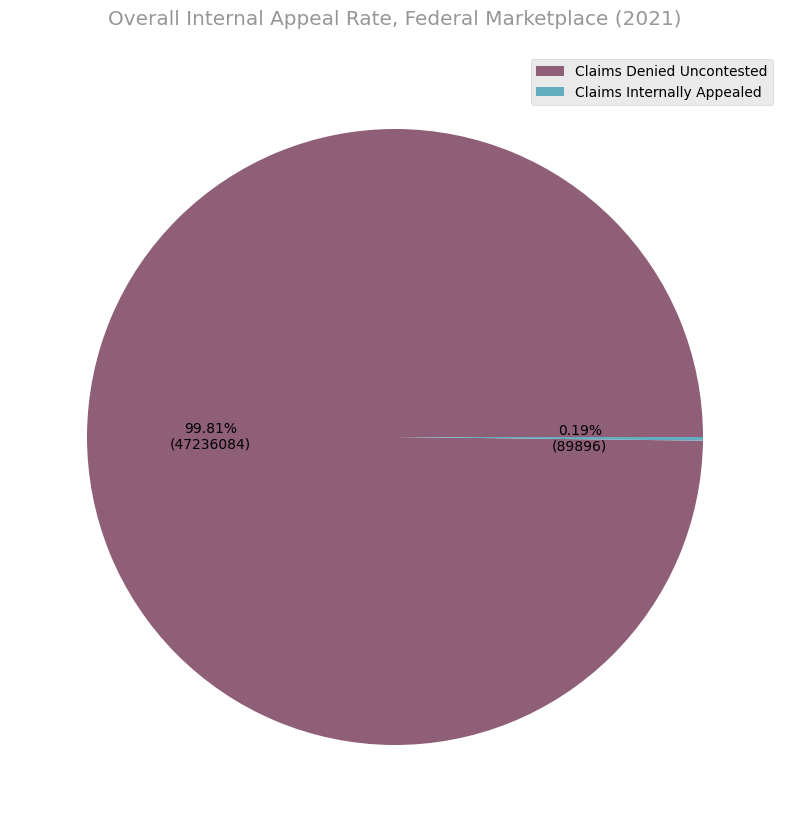

In [105]:
#### Internal Appeal Rate
claims_denied = (
    issuer_internal[~issuer_internal["Issuer_Claims_Denials"].isnull()][
        "Issuer_Claims_Denials"
    ]
    .astype(int)
    .sum()
)

# Issuer_Internal_Appeals_Filed

# Issuer_Number_Internal_Appeals_Overturned

claims_internally_appealed = (
    issuer_internal[~issuer_internal["Issuer_Internal_Appeals_Filed"].isnull()][
        "Issuer_Internal_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[claims_denied - claims_internally_appealed, claims_internally_appealed],
    title="Overall Internal Appeal Rate, Federal Marketplace (2021)",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "internal_appeal_rates_all_insurers.png"),
    show=True,
)

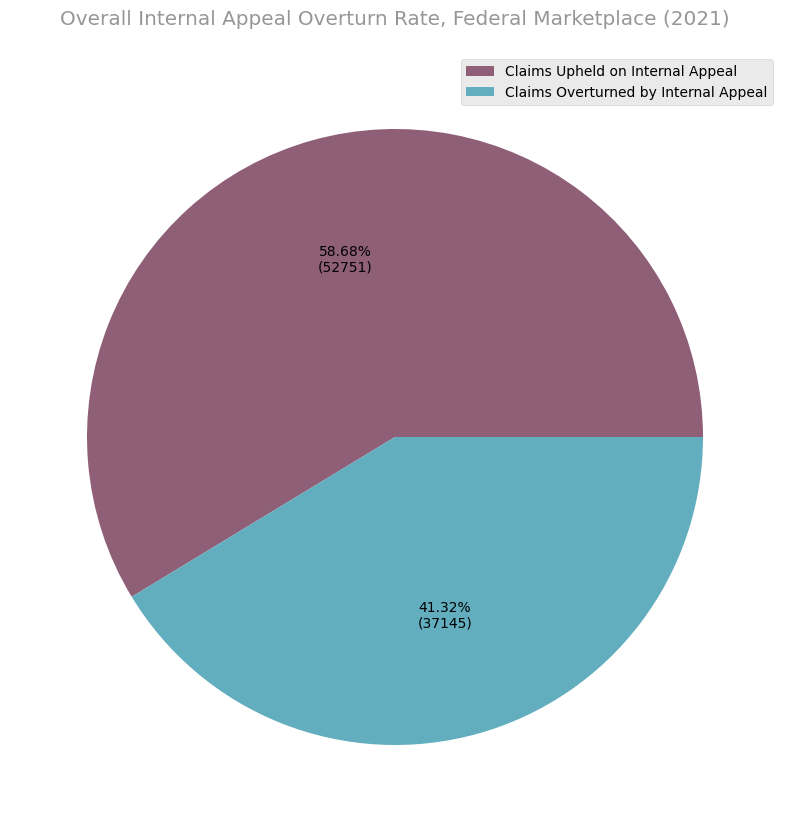

In [106]:
#### Internal Appeal Success Rate
claims_internally_overturned = (
    issuer_internal[
        ~issuer_internal["Issuer_Number_Internal_Appeals_Overturned"].isnull()
    ]["Issuer_Number_Internal_Appeals_Overturned"]
    .astype(int)
    .sum()
)

claims_internally_appealed = (
    issuer_internal[~issuer_internal["Issuer_Internal_Appeals_Filed"].isnull()][
        "Issuer_Internal_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned by Internal Appeal",
    ],
    slice_vals=[
        claims_internally_appealed - claims_internally_overturned,
        claims_internally_overturned,
    ],
    title="Overall Internal Appeal Overturn Rate, Federal Marketplace (2021)",
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "internal_appeal_success_rates_all_insurers.png"
    ),
    show=True,
)

##### Among Issuers Reporting External Appeals Data

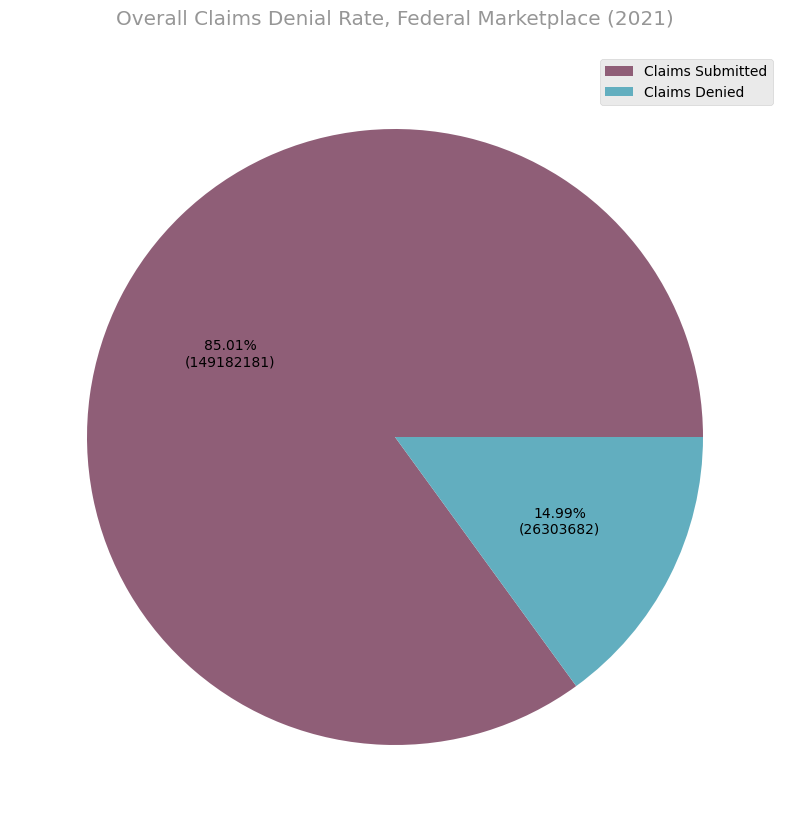

In [107]:
#### Denial Rate Among those reporting External
claims_received = (
    issuer_external[~issuer_external["Issuer_Claims_Received"].isnull()][
        "Issuer_Claims_Received"
    ]
    .astype(int)
    .sum()
)
claims_denied = (
    issuer_external[~issuer_external["Issuer_Claims_Denials"].isnull()][
        "Issuer_Claims_Denials"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=["Claims Submitted", "Claims Denied"],
    slice_vals=[claims_received - claims_denied, claims_denied],
    title="Overall Claims Denial Rate, Federal Marketplace (2021)",
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "denial_rates_insurers_w_external_appeal_data.png"
    ),
    show=True,
)

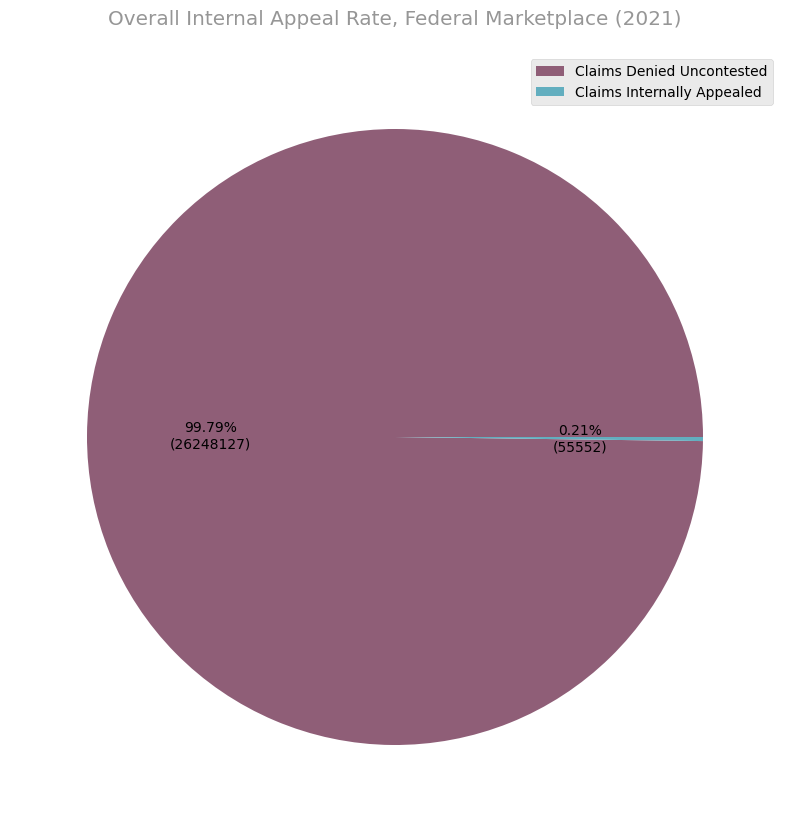

In [108]:
#### Internal Appeal Rate
claims_denied = (
    issuer_external[~issuer_external["Issuer_Claims_Denials"].isnull()][
        "Issuer_Claims_Denials"
    ]
    .astype(int)
    .sum()
)

# Issuer_Internal_Appeals_Filed

# Issuer_Number_Internal_Appeals_Overturned

claims_internally_appealed = (
    issuer_external[~issuer_external["Issuer_Internal_Appeals_Filed"].isnull()][
        "Issuer_Internal_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=["Claims Denied Uncontested", "Claims Internally Appealed"],
    slice_vals=[claims_denied - claims_internally_appealed, claims_internally_appealed],
    title="Overall Internal Appeal Rate, Federal Marketplace (2021)",
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "internal_appeal_rates_insurers_w_external_data.png"
    ),
    show=True,
)

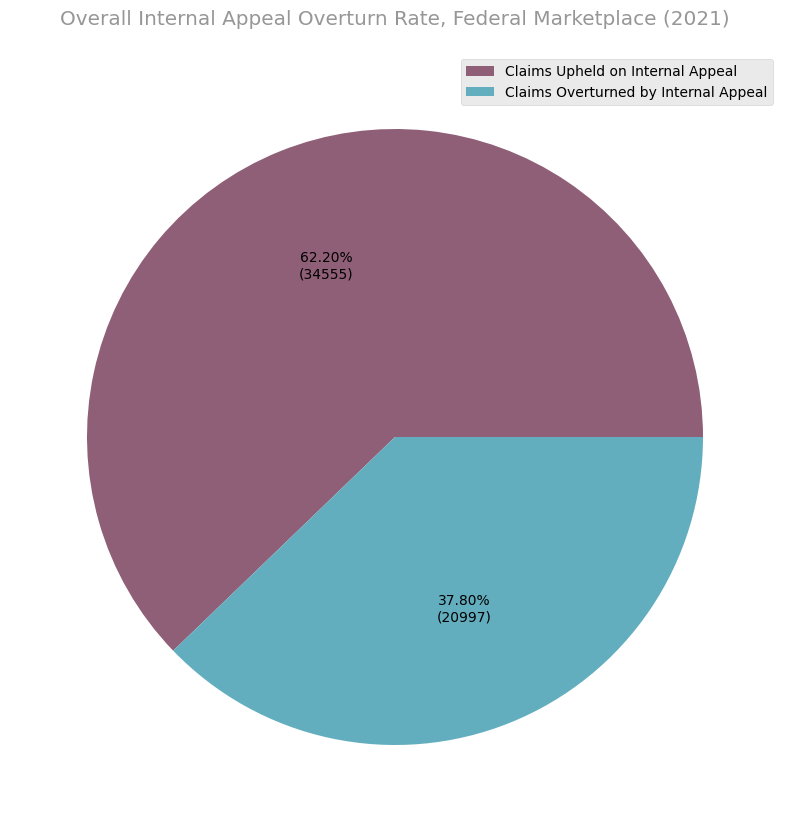

In [109]:
#### Internal Appeal Success Rate
claims_internally_overturned = (
    issuer_external[
        ~issuer_external["Issuer_Number_Internal_Appeals_Overturned"].isnull()
    ]["Issuer_Number_Internal_Appeals_Overturned"]
    .astype(int)
    .sum()
)

claims_internally_appealed = (
    issuer_external[~issuer_external["Issuer_Internal_Appeals_Filed"].isnull()][
        "Issuer_Internal_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)
claims_upheld = claims_internally_appealed - claims_internally_overturned

plot_pie(
    slice_names=[
        "Claims Upheld on Internal Appeal",
        "Claims Overturned by Internal Appeal",
    ],
    slice_vals=[claims_upheld, claims_internally_overturned],
    title="Overall Internal Appeal Overturn Rate, Federal Marketplace (2021)",
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "internal_appeal_success_rates_insurers_w_external_data.png"
    ),
    show=True,
)

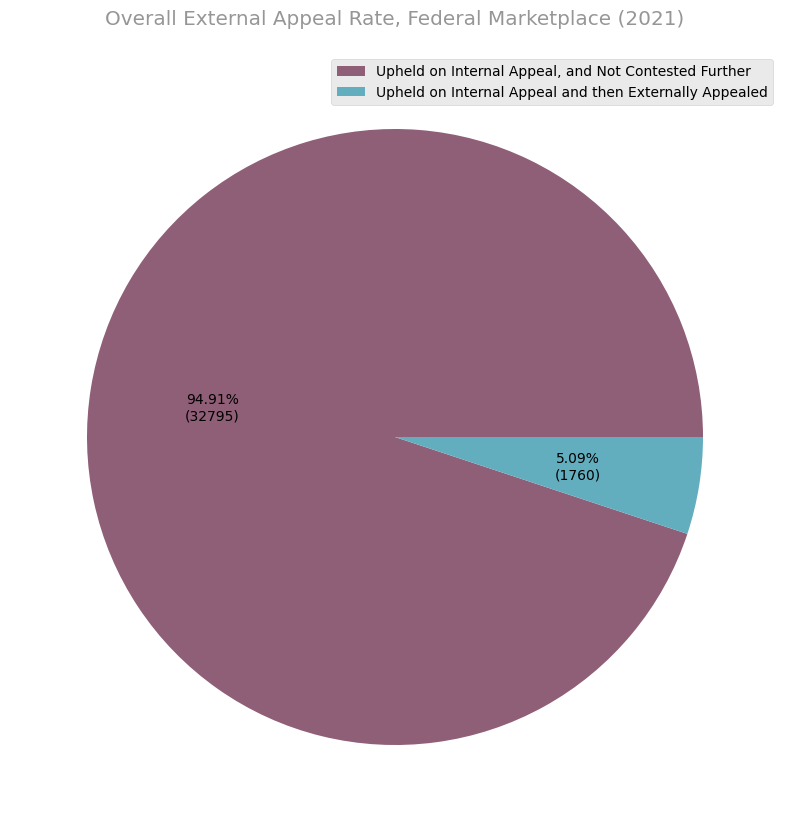

In [110]:
#### External Appeal Rate
claims_externally_appealed = (
    issuer_external[~issuer_external["Issuer_External_Appeals_Filed"].isnull()][
        "Issuer_External_Appeals_Filed"
    ]
    .astype(int)
    .sum()
)

plot_pie(
    slice_names=[
        "Upheld on Internal Appeal, and Not Contested Further",
        "Upheld on Internal Appeal and then Externally Appealed",
    ],
    slice_vals=[claims_upheld - claims_externally_appealed, claims_externally_appealed],
    title="Overall External Appeal Rate, Federal Marketplace (2021)",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_rates_all_insurers.png"),
    show=True,
)

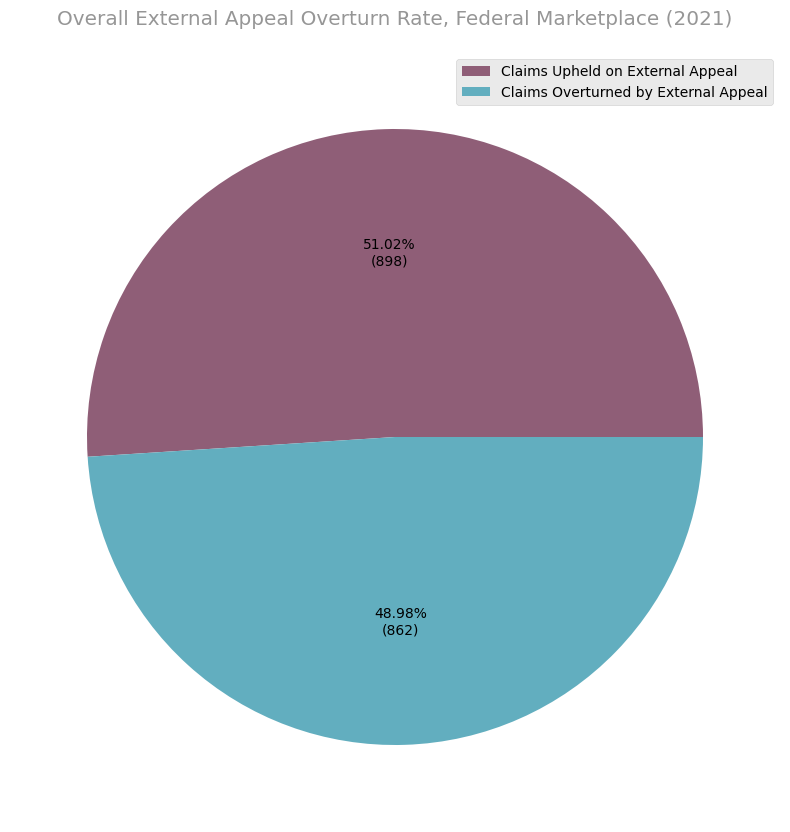

In [111]:
#### External Appeal Success Rate
claims_externally_overturned = (
    issuer_external[
        ~issuer_external["Issuer_Number_External_Appeals_Overturned"].isnull()
    ]["Issuer_Number_External_Appeals_Overturned"]
    .astype(int)
    .sum()
)
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="Overall External Appeal Overturn Rate, Federal Marketplace (2021)",
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

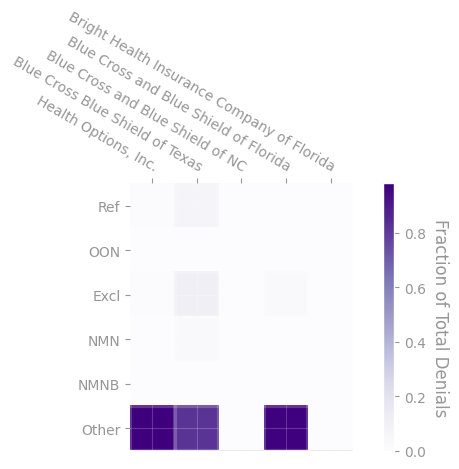

In [112]:
# Construct heatmap of denial rationales for the top_k largest insurers in data (by claims counts)
top_k_insurers = 5
cats1 = [
    "Plan_Number_Claims_Denied_Referral_Required",
    "Plan_Number_Claims_Denied_Out_of_Network",
    "Plan_Number_Claims_Denied_Services_Excluded",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Excl_Behavioral_Health",
    "Plan_Number_Claims_Denied_Not_Medically_Necessary_Behavioral_Health_Only",
    "Plan_Number_Claims_Denied_Other",
]
cats2 = list(
    issuer_base.sort_values(by=["Issuer_Claims_Received"], ascending=False)[
        "Issuer_Name"
    ][:top_k_insurers].values
)

arr = np.zeros((len(cats1), len(cats2)))
for idx, row in plan_breakdown_oon_incl.iterrows():
    try:
        col_idx = cats2.index(row["Issuer_Name"])
        tot = 0
        for idx, cat in enumerate(cats1):
            arr[idx, col_idx] += row[cat]
            tot += row[cat]
        if tot > 0:
            arr[:, col_idx] /= tot
    except ValueError:
        pass
fig, ax = plt.subplots()

# Make names shorter for sake of plot
cats1 = ["Ref", "OON", "Excl", "NMN", "NMNB", "Other"]
im, cbar = heatmap(
    arr, cats1, cats2, ax=ax, cmap="Purples", cbarlabel="Fraction of Total Denials"
)
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()